In [8]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import missingno as msno
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from catboost import Pool
import shap
import missingno as msno
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import datetime

Считываем данные

In [2]:
train_df = pd.read_csv("train-2.csv", index_col="id")
test_df = pd.read_csv("test-2.csv")

In [3]:
train_df.head()

,date,street_id,build_tech,floor,area,rooms,balcon,metro_dist,g_lift,n_photos,...,kw5,kw6,kw7,kw8,kw9,kw10,kw11,kw12,kw13,price
id,,,,,,,,,,,,,,,,,,,,,
0,2011-1,560,NaN,2,59,3,0,30.0,1.0,5,...,0,0,0,0,0,0,0,0,0,4510000
1,2011-1,667,NaN,10,50,2,1,25.0,NaN,1,...,0,0,0,0,0,0,0,0,0,13231000
2,2011-1,90,0.0,1,48,2,0,25.0,0.0,1,...,0,0,0,0,0,0,0,0,0,2008000
3,2011-1,94,1.0,3,62,3,1,30.0,NaN,3,...,0,0,0,0,0,0,0,0,0,12680000
4,2011-1,232,0.0,3,60,3,0,25.0,NaN,3,...,0,0,0,0,0,0,0,0,0,3335000


Заменим строковый столбец date на два целочисленных столбца - month и year, чтобы модель могла с ними работать.

In [4]:
train_df['date'] = pd.to_datetime(train_df['date'])

train_df['year'] = train_df['date'].dt.year
train_df['month'] = train_df['date'].dt.month
train_df.drop(columns=['date'], inplace=True)

In [5]:
test_df['date'] = pd.to_datetime(test_df['date'])

test_df['year'] = test_df['date'].dt.year
test_df['month'] = test_df['date'].dt.month
test_df.drop(columns=['date'], inplace=True)

Уберем столбец id из тестового датасета

In [7]:
test_df.drop(columns=['id'], inplace=True)

In [9]:
train_df.shape

(100000, 25)

In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 25 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   street_id   100000 non-null  int64  
 1   build_tech  70265 non-null   float64
 2   floor       100000 non-null  int64  
 3   area        100000 non-null  int64  
 4   rooms       100000 non-null  int64  
 5   balcon      100000 non-null  int64  
 6   metro_dist  95104 non-null   float64
 7   g_lift      70008 non-null   float64
 8   n_photos    100000 non-null  int64  
 9   kw1         100000 non-null  int64  
 10  kw2         100000 non-null  int64  
 11  kw3         100000 non-null  int64  
 12  kw4         100000 non-null  int64  
 13  kw5         100000 non-null  int64  
 14  kw6         100000 non-null  int64  
 15  kw7         100000 non-null  int64  
 16  kw8         100000 non-null  int64  
 17  kw9         100000 non-null  int64  
 18  kw10        100000 non-null  int64  
 19  kw1

In [11]:
train_df.describe()

,street_id,build_tech,floor,area,rooms,balcon,metro_dist,g_lift,n_photos,kw1,...,kw7,kw8,kw9,kw10,kw11,kw12,kw13,price,year,month
count,100000.000000,70265.000000,100000.000000,100000.00000,100000.000000,100000.000000,95104.000000,70008.000000,100000.000000,100000.000000,...,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.00000,1.000000e+05,100000.000000,100000.000000
mean,334.479290,0.529837,5.267680,52.25343,2.118680,0.396740,22.154431,0.500986,2.470910,0.055650,...,0.000940,0.007910,0.007890,0.00218,0.000320,0.001210,0.00021,5.138396e+06,2011.331550,6.510570
std,194.004755,0.573645,3.905558,17.79250,0.829688,0.547632,8.286241,0.500003,1.944981,0.229246,...,0.030645,0.088586,0.088475,0.04664,0.017886,0.034764,0.01449,4.187469e+06,0.470773,3.862589
min,0.000000,0.000000,1.000000,29.00000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,4.480000e+05,2011.000000,1.000000
25%,167.000000,0.000000,2.000000,40.00000,1.000000,0.000000,15.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,2.644000e+06,2011.000000,3.000000
50%,334.000000,0.000000,4.000000,52.00000,2.000000,0.000000,25.000000,1.000000,2.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,4.090000e+06,2011.000000,7.000000
75%,501.000000,1.000000,7.000000,60.00000,3.000000,1.000000,30.000000,1.000000,4.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,6.281000e+06,2012.000000,10.000000
max,671.000000,2.000000,25.000000,217.00000,6.000000,2.000000,30.000000,1.000000,11.000000,1.000000,...,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.00000,8.054800e+07,2012.000000,12.000000


Посмотрим количество пропусков в данных

In [12]:
train_df.isna().sum()

street_id         0
build_tech    29735
floor             0
area              0
rooms             0
balcon            0
metro_dist     4896
g_lift        29992
n_photos          0
kw1               0
kw2               0
kw3               0
kw4               0
kw5               0
kw6               0
kw7               0
kw8               0
kw9               0
kw10              0
kw11              0
kw12              0
kw13              0
price             0
year              0
month             0
dtype: int64

Посмотрим количество пропусков в процентах, относительно размера тренеровочного датасета

In [13]:
train_df.isna().mean() * 100

street_id      0.000
build_tech    29.735
floor          0.000
area           0.000
rooms          0.000
balcon         0.000
metro_dist     4.896
g_lift        29.992
n_photos       0.000
kw1            0.000
kw2            0.000
kw3            0.000
kw4            0.000
kw5            0.000
kw6            0.000
kw7            0.000
kw8            0.000
kw9            0.000
kw10           0.000
kw11           0.000
kw12           0.000
kw13           0.000
price          0.000
year           0.000
month          0.000
dtype: float64

Посмотрим сколько данных мы потерям, если просто избавимся от данных с пропусками

In [14]:
train_df_drop = train_df.copy(deep=True)
train_df_drop.dropna(how="any", inplace=True)
print(f"Количество строк до удаления пропущенных значений: {train_df.shape[0]}")
print(f"Количество строк после удаления пропущенных значений: {train_df_drop.shape[0]}")

Количество строк до удаления пропущенных значений: 100000
Количество строк после удаления пропущенных значений: 46753


Как видно, если просто удалить пропущенные значения, мы потеряем больше половины данных, что очень плохо. Постараемся заполнить пропуски в данных.

### Библиотека missingno
Библиотека missingno предоставляет удобные средства для визуальной оценки пропусков.

In [20]:
sns.set()

<Axes: >

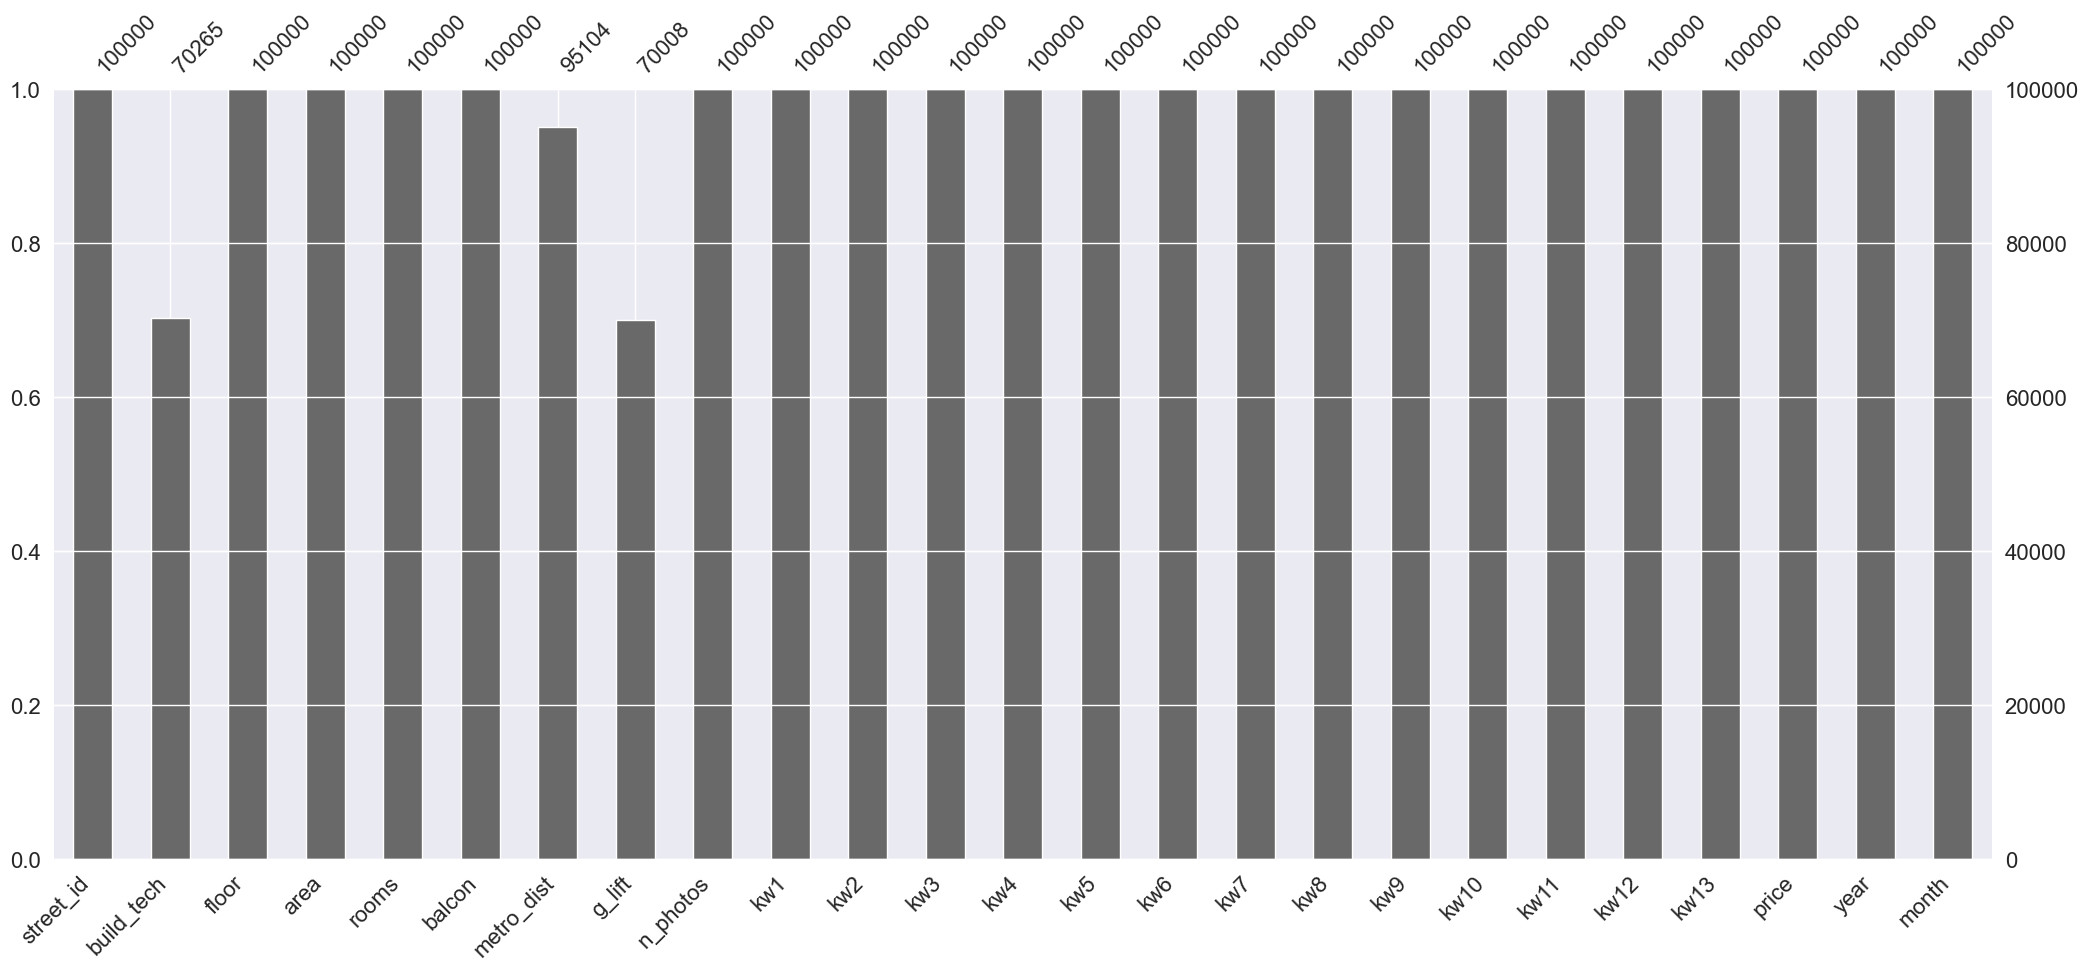

In [21]:
msno.bar(train_df)

Матрица пропущенных значений:

<Axes: >

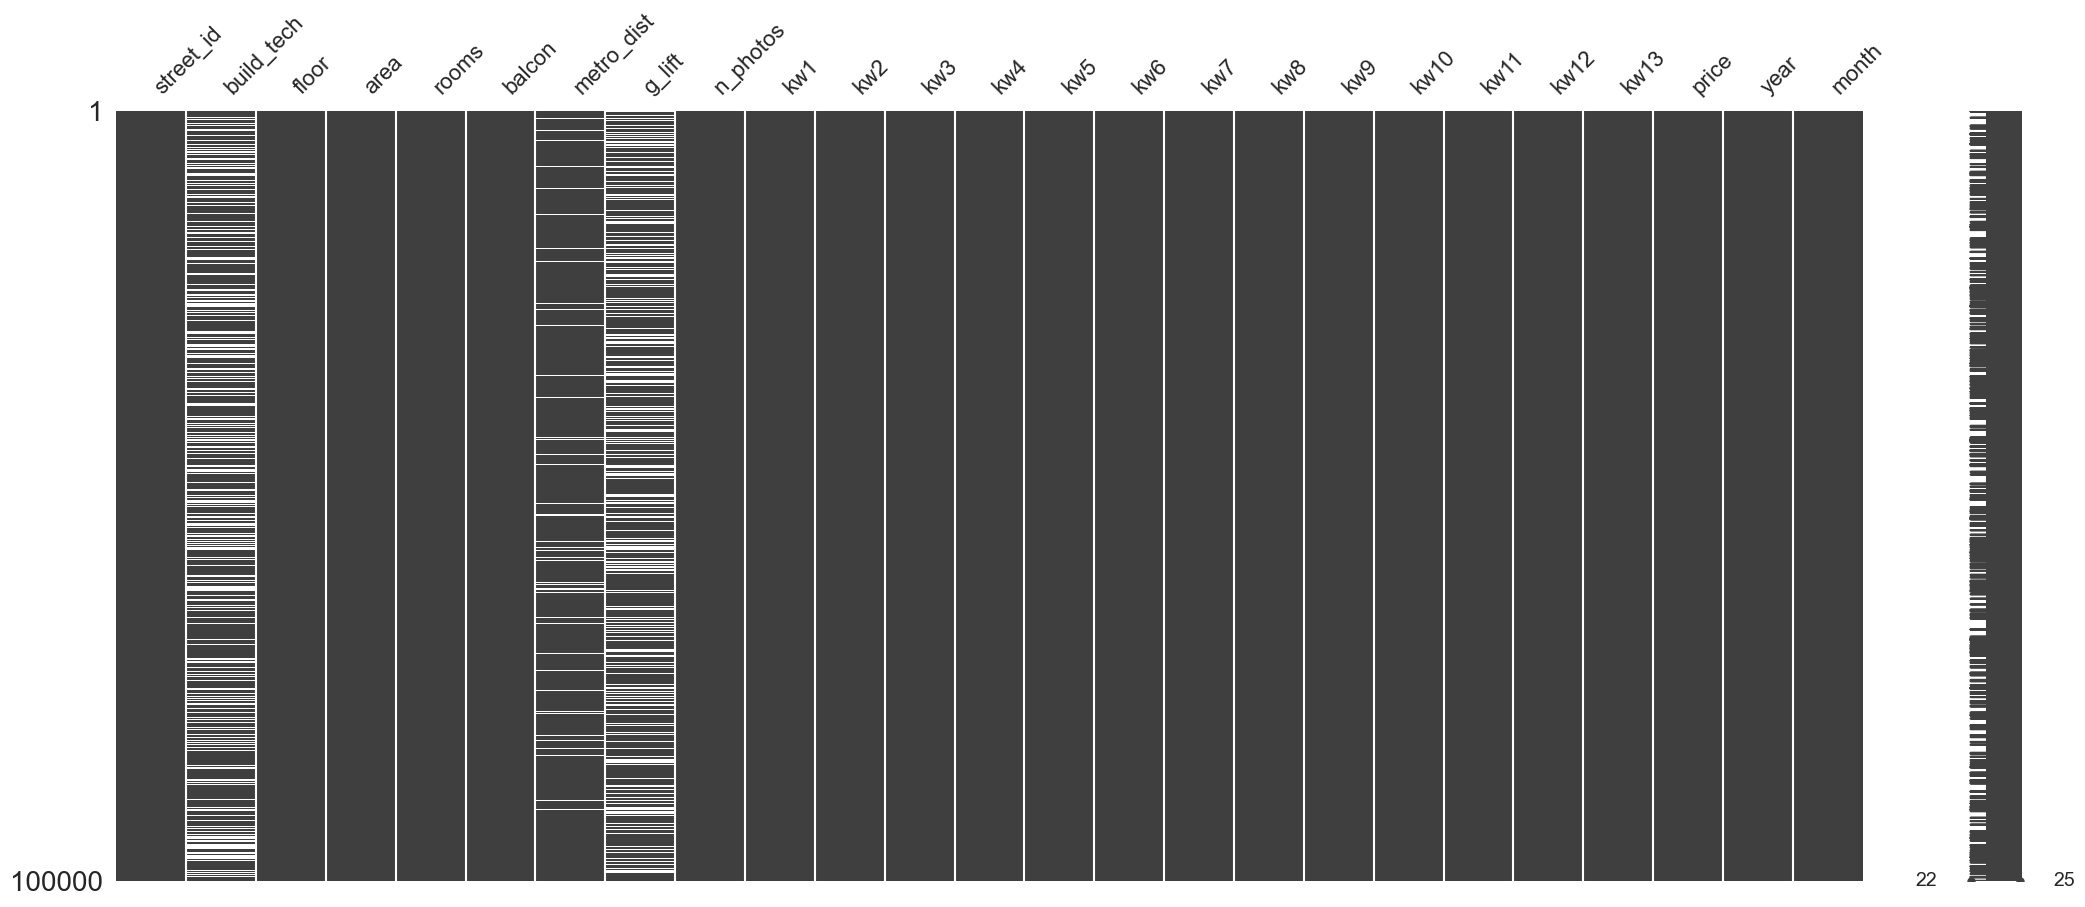

In [22]:
msno.matrix(train_df)

Распределение пропущенных значений в датасете выглядит случайным, закономерностью были бы пропуски, например, только в первой половине наблюдений.

Матрица корреляции пропущенных значений

In [23]:
train_df[["g_lift", "build_tech", "metro_dist"]].isnull().corr()

,g_lift,build_tech,metro_dist
g_lift,1.000000,-0.004446,0.001273
build_tech,-0.004446,1.000000,0.000727
metro_dist,0.001273,0.000727,1.000000


<Axes: >

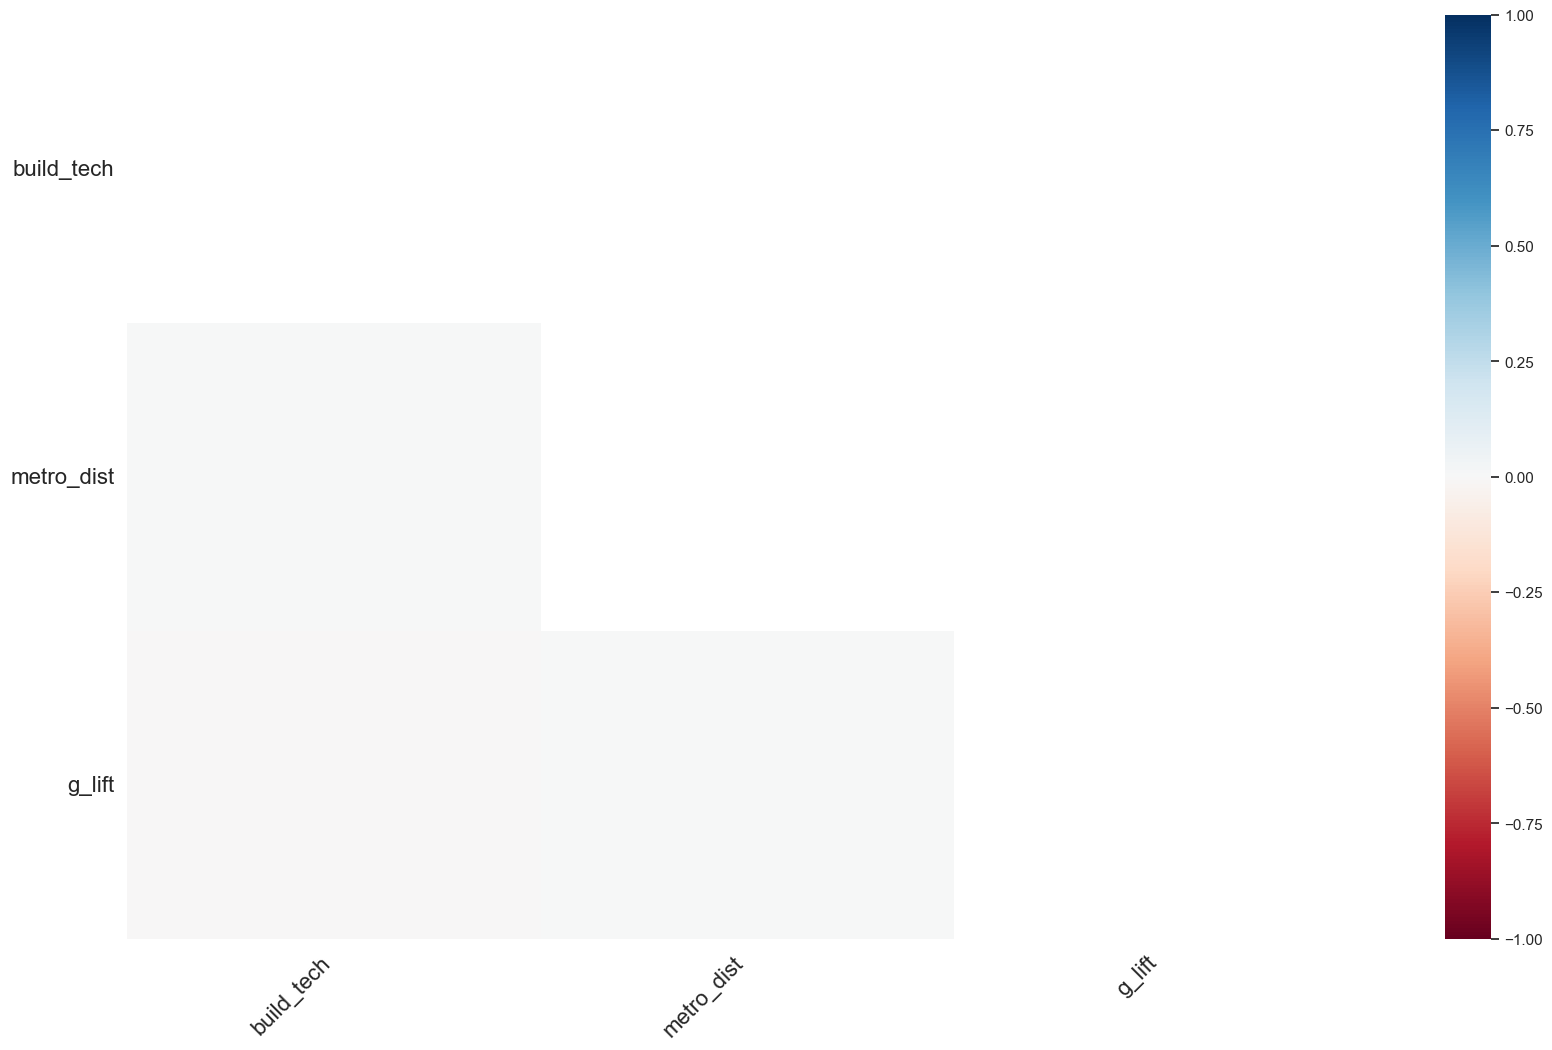

In [24]:
msno.heatmap(train_df)

Мы видим, что корреляция пропусков близка к нулю для всех признаков. Другими словами, пропуски одного признака не влияют на пропуски другого.

## Работа с пропусками

## Идеи:
- Корреляция между g_lift и kw(может быть одно из ключевых слов - лифт)
- Для квартир на этаже больше 5 если пропущенно значение, можно предположить, что значение g_lift равно 1, т.к. если в доме больше 6 этажей, скорее всего там есть лифт
- Посмотреть корреляцию между количеством этажей и build_tech(непонятно пока что такой build_tech, но возможно это тип недвижемости).
- Посмотреть корреляцию между build_tech и metro_dist, если предположение о том, что build_tech - тип недвижемости верно, скорее всего растояние от дома до метро будет больше, чем расстояние от квартиры до метро. Что будет означать, что можно сгруппировать данные по build_tech и заполнять пропуски в metro_dist по группам.

Посмотрим как связаны значения ключевых слов, от значения g_lift

In [25]:
for i in range(1, 14):
    kw = 'kw'
    print(f"Значения для ключевого слова {kw + str(i)}, где g_lift = 1: {train_df[train_df['g_lift'] == 1][kw + str(i)].value_counts()}")

Значения для ключевого слова kw1, где g_lift = 1: 0    33106
1     1967
Name: kw1, dtype: int64
Значения для ключевого слова kw2, где g_lift = 1: 1    21958
0    13115
Name: kw2, dtype: int64
Значения для ключевого слова kw3, где g_lift = 1: 0    34831
1      242
Name: kw3, dtype: int64
Значения для ключевого слова kw4, где g_lift = 1: 0    34873
1      200
Name: kw4, dtype: int64
Значения для ключевого слова kw5, где g_lift = 1: 0    34928
1      145
Name: kw5, dtype: int64
Значения для ключевого слова kw6, где g_lift = 1: 0    35033
1       40
Name: kw6, dtype: int64
Значения для ключевого слова kw7, где g_lift = 1: 0    35043
1       30
Name: kw7, dtype: int64
Значения для ключевого слова kw8, где g_lift = 1: 0    34801
1      272
Name: kw8, dtype: int64
Значения для ключевого слова kw9, где g_lift = 1: 0    34790
1      283
Name: kw9, dtype: int64
Значения для ключевого слова kw10, где g_lift = 1: 0    34995
1       78
Name: kw10, dtype: int64
Значения для ключевого слова kw11, где

In [26]:
for i in range(1, 14):
    kw = 'kw'
    print(f"Значения для ключевого слова {kw + str(i)}, где g_lift = 1: {train_df[train_df['g_lift'] == 0][kw + str(i)].value_counts()}")

Значения для ключевого слова kw1, где g_lift = 1: 0    33007
1     1928
Name: kw1, dtype: int64
Значения для ключевого слова kw2, где g_lift = 1: 1    22178
0    12757
Name: kw2, dtype: int64
Значения для ключевого слова kw3, где g_lift = 1: 0    34656
1      279
Name: kw3, dtype: int64
Значения для ключевого слова kw4, где g_lift = 1: 0    34707
1      228
Name: kw4, dtype: int64
Значения для ключевого слова kw5, где g_lift = 1: 0    34786
1      149
Name: kw5, dtype: int64
Значения для ключевого слова kw6, где g_lift = 1: 0    34879
1       56
Name: kw6, dtype: int64
Значения для ключевого слова kw7, где g_lift = 1: 0    34904
1       31
Name: kw7, dtype: int64
Значения для ключевого слова kw8, где g_lift = 1: 0    34657
1      278
Name: kw8, dtype: int64
Значения для ключевого слова kw9, где g_lift = 1: 0    34638
1      297
Name: kw9, dtype: int64
Значения для ключевого слова kw10, где g_lift = 1: 0    34859
1       76
Name: kw10, dtype: int64
Значения для ключевого слова kw11, где

Как видно никакой зависимости нет.

Посмотрим как отличаются значения build_tech в зависимости от этажа, если build_tech - тип недвижемости и одно из значений, например, обозначает дом, то значение build_tech может отличаться в зависимости от этажа.

Все значения, которые принимает build_tech:

In [28]:
train_df['build_tech'].value_counts()

0.0    35845
1.0    31611
2.0     2809
Name: build_tech, dtype: int64

Значения build_tech для объектов, у которых этаж больше 11:

In [30]:
train_df[train_df['floor'] > 11]['build_tech'].value_counts(dropna=False)

NaN    1912
0.0    1653
1.0    1525
2.0    1385
Name: build_tech, dtype: int64

Значения build_tech для объектов, у которых этаж больше 12:

In [31]:
train_df[train_df['floor'] > 12]['build_tech'].value_counts(dropna=False)

2.0    1236
NaN     854
0.0     718
Name: build_tech, dtype: int64

Как видно, для объектов, у которых этаж больше 12, build_tech принимает только значения - 0, 2. Что стоит учитывать, при заполнении пропусков для build_tech.

Теперь посмотрим как влияет build_tech на наличие лифта(возможно если build_tech 2 или 0, то лифт должен быть)

In [32]:
train_df[train_df['build_tech'] == 0]['g_lift'].value_counts(dropna=False)

0.0    12565
1.0    12480
NaN    10800
Name: g_lift, dtype: int64

In [33]:
train_df[train_df['build_tech'] == 1]['g_lift'].value_counts(dropna=False)

1.0    11066
0.0    10943
NaN     9602
Name: g_lift, dtype: int64

In [34]:
train_df[train_df['build_tech'] == 2]['g_lift'].value_counts(dropna=False)

1.0    1044
0.0    1000
NaN     765
Name: g_lift, dtype: int64

Нет, никакой зависимости нет

Теперь посмотрим наличие лифта для недвижемостей с количеством этажей большим 5

In [35]:
train_df[train_df['floor'] > 5]['g_lift'].value_counts(dropna=False)

1.0    12224
0.0    12092
NaN    10456
Name: g_lift, dtype: int64

Большим 10

In [36]:
train_df[train_df['floor'] > 10]['g_lift'].value_counts(dropna=False)

1.0    3552
0.0    3488
NaN    3016
Name: g_lift, dtype: int64

Большим 20

In [37]:
train_df[train_df['floor'] > 20]['g_lift'].value_counts(dropna=False)

1.0    380
0.0    379
NaN    315
Name: g_lift, dtype: int64

Окей, этаж недвижемости не влияет на наличия лифта, наше предположение неверно

Посмотрим как влияет build_tech на расстояние до метро. Продолжая предполагать, что build_tech - тип недвижемости и одно из его значений обозначает дом, можно выдвинуть предположение что для этого значения build_tech расстояние до метро в среднем будет больше, чем расстояние до метро от значения build_tech, которое обозначает квартиру. Так как растояние от квартиры до метро обычно меньше, чем расстояние до метро от дома.

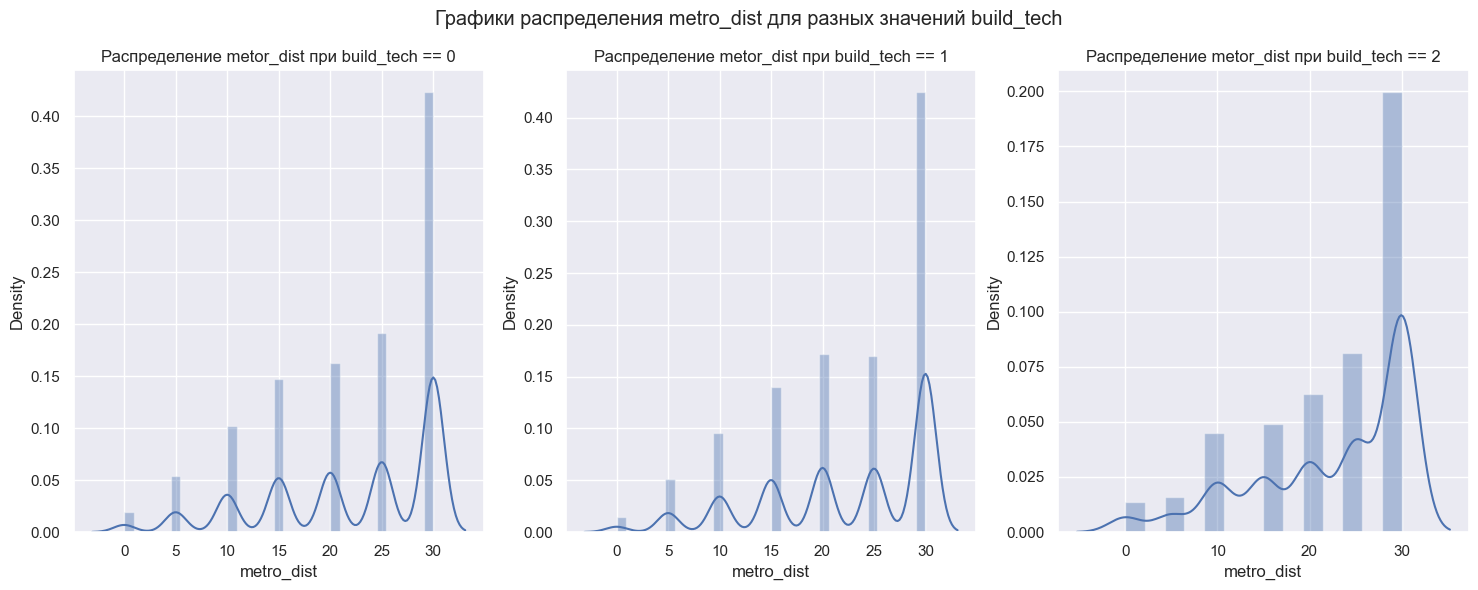

In [42]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))  # 1 строка, 3 столбца

sns.distplot(train_df[train_df['build_tech'] == 0]['metro_dist'], ax=axes[0])
axes[0].set_title('Распределение metor_dist при build_tech == 0')

sns.distplot(train_df[train_df['build_tech'] == 1]['metro_dist'], ax=axes[1])
axes[1].set_title('Распределение metor_dist при build_tech == 1')

sns.distplot(train_df[train_df['build_tech'] == 2]['metro_dist'], ax=axes[2])
axes[2].set_title('Распределение metor_dist при build_tech == 2')

fig.suptitle('Графики распределения metro_dist для разных значений build_tech')
plt.show()

Видно, что для build_tech равным 0 и 1 распределение metro_dist почти не отличается, но при build_tech = 2 распределение другое. Что значит, что при заполнении пропусков в metro_dist, можно будет разбить данные на группы по build_tech и заполнять их.

Посмотрим какие значения принимает переменная rooms при разных значениях build_tech

In [43]:
train_df[train_df['build_tech'] == 2]['rooms'].value_counts(dropna=False)

3    904
2    893
1    888
4    104
6     20
Name: rooms, dtype: int64

In [44]:
train_df[train_df['build_tech'] == 1]['rooms'].value_counts(dropna=False)

3    12502
2    12223
1     6174
4      411
5      301
Name: rooms, dtype: int64

In [45]:
train_df[train_df['build_tech'] == 0]['rooms'].value_counts(dropna=False)

1    12000
3    11978
2    11867
Name: rooms, dtype: int64

 - ### Возможное кол-во комнат для build_tech == 0:
 [1, 2, 3]
 - ### Возможное кол-во комнат для build_tech == 1:
 [1, 2, 3, 4, 5]
 - ### Возможное кол-во комнат для build_tech == 2:
 [1, 2, 3, 4, 6]

То есть, как будто можно сделать вывод, что если rooms == 5, то build_tech == 1, если rooms == 6, то build_tech == 2

## Итого что мы получили
 - Прежде всего обучим первую модель, просто удалив все пропуски из данных, чтобы иметь точку отсчета.
 - саначала заполним пропуски для build_tech, потому что для заполнения пропусков в других данных выгодно разбивать данные по группам по build_tech
     - ### Как заполнять данные для build_tech?
      - Первое что мы выяснили, что если количество комнат равно 5, то build_tech равно 1
      - Второе - если количество комнат равно 6, то build_tech равно 2
      - Так же мы заметили странность при сравнении количества ключевого слова 2(kw2) в объявлении при разных build_tech. То есть, при build_tech равным 0 или 1, в большенстве случаев kw2 равно 1, в то время как для build_tech равным 2 kw2 чаще равняется 0, чем единице, можно попробовать как-то это учитывать.
      - И послднее: для недвижемости, у которой этаж больше 12 build_tech может быть равен только либо 0 либо 2
 - После заполнения пропусков в build_tech можем перейти к заполнению пропуков в признаках metro_dist и g_lift. Здесь стоит разбить данные по build_tech на три группы и заполнять данные внутри групп.
 - После заполнения всех пропусков поработает над выбросами. Постараемся найти и избавиться от аномальных значений
 - Посмотрим на промежуточное качество.
  - Дальше попробуем сгенирировать новые признаки.
 - Посмотрим на важность признаков и избавимся от неинформативных признаков.

## Первая модель - линейная регрессия на данных, где мы просто удалил пропуски

In [47]:
first_model = LinearRegression()

In [48]:
X = train_df_drop.drop(columns=["price"])
y = train_df_drop["price"]

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)

In [50]:
first_model.fit(X_train, y_train)

LinearRegression()

In [51]:
y_pred = first_model.predict(X_test)

In [52]:
mean_absolute_error(y_test, y_pred)

1816732.7293614259

## Перейдем к заполнению пропусков

Скопируем на всякий случай датасеты

In [53]:
train_df_fill = train_df.copy(deep=True)
test_df_fill = test_df.copy(deep=True)

Заполняем пропуски build_tech значение 1, где количество комнат равно 5

In [54]:
train_df_fill[(train_df_fill['rooms'] == 5) & (train_df_fill['build_tech'].isna())]

,street_id,build_tech,floor,area,rooms,balcon,metro_dist,g_lift,n_photos,kw1,...,kw7,kw8,kw9,kw10,kw11,kw12,kw13,price,year,month
id,,,,,,,,,,,,,,,,,,,,,
1266,62,NaN,1,183,5,1,30.0,1.0,3,0,...,0,0,0,0,0,0,0,1000000,2011,1
1336,640,NaN,9,182,5,0,30.0,0.0,7,0,...,0,0,0,0,0,0,0,24452000,2011,1
1750,190,NaN,12,185,5,1,20.0,1.0,0,0,...,0,0,0,1,0,0,0,18272000,2011,1
2067,13,NaN,1,185,5,1,5.0,NaN,7,0,...,0,0,0,1,0,0,0,21759000,2011,1
2547,500,NaN,4,184,5,0,30.0,1.0,8,0,...,0,0,0,0,0,0,0,28318000,2011,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93870,485,NaN,5,183,5,1,25.0,0.0,7,0,...,0,0,0,0,0,0,0,17599000,2012,2
94372,27,NaN,1,183,5,0,NaN,0.0,2,1,...,0,0,0,0,0,0,0,24657000,2012,2
94797,621,NaN,11,183,5,1,25.0,0.0,5,0,...,0,0,0,0,0,0,0,26832000,2012,3


In [55]:
train_df_fill.loc[(train_df_fill['rooms'] == 5) & 
                  (train_df_fill['build_tech'].isna()), 'build_tech'] = 1

In [56]:
test_df_fill.loc[(test_df_fill['rooms'] == 5) & 
                 (test_df_fill['build_tech'].isna()), 'build_tech'] = 1

Заполняем пропуски build_tech значение 2, где количество комнат равно 6

In [57]:
train_df_fill[(train_df_fill['rooms'] == 6) & (train_df_fill['build_tech'].isna())]

,street_id,build_tech,floor,area,rooms,balcon,metro_dist,g_lift,n_photos,kw1,...,kw7,kw8,kw9,kw10,kw11,kw12,kw13,price,year,month
id,,,,,,,,,,,,,,,,,,,,,
10967,211,NaN,6,215,6,0,30.0,1.0,4,0,...,0,0,0,0,0,0,0,19265000,2011,10
11883,211,NaN,2,215,6,2,30.0,0.0,2,0,...,0,0,0,0,0,0,0,20749000,2011,11
18674,614,NaN,7,215,6,2,10.0,NaN,9,0,...,0,0,0,0,0,0,0,47239000,2011,12
23989,21,NaN,1,214,6,2,20.0,1.0,6,0,...,0,0,0,0,0,0,0,23401000,2011,2
25605,633,NaN,11,215,6,0,20.0,1.0,4,0,...,0,0,0,0,0,0,0,28780000,2011,2
35200,303,NaN,5,213,6,2,30.0,1.0,8,0,...,0,0,0,0,0,0,0,31348000,2011,4
39654,33,NaN,4,215,6,2,20.0,NaN,4,0,...,0,0,0,0,0,0,0,27967000,2011,5
47602,75,NaN,12,215,6,2,20.0,1.0,1,0,...,0,0,0,0,0,0,0,16279000,2011,6
65630,595,NaN,10,215,6,2,25.0,1.0,0,0,...,0,0,0,0,0,0,0,25406000,2011,9


In [58]:
train_df_fill.loc[(train_df_fill['rooms'] == 6) & 
                  (train_df_fill['build_tech'].isna()), 'build_tech'] = 2

In [59]:
test_df_fill.loc[(test_df_fill['rooms'] == 6) & 
                  (test_df_fill['build_tech'].isna()), 'build_tech'] = 2

### Заполнение внутригрупповым значением

Будем бить на группы по этажу и количеству комнат, так как мы заметили, что возможное количество комнат отличается для разных значений build_tech, а также что при этаже большем 12 build_tech может быть равен только 0 и 2.

Для тренировачного датасета:

In [60]:
bt_bins_train = train_df_fill.groupby(['floor', "rooms"])
bt_bins_train.build_tech.median()

floor  rooms
1      1        0.0
       2        1.0
       3        1.0
       4        1.0
       5        1.0
               ... 
24     2        2.0
       3        2.0
25     1        2.0
       2        2.0
       3        2.0
Name: build_tech, Length: 110, dtype: float64

In [61]:
train_df_fill.build_tech = bt_bins_train.build_tech.apply(lambda x: x.fillna(x.median()))

Проверм, что пропусков в build_tech больше нет

In [63]:
train_df_fill.build_tech.isna().sum()

0

Для тестового датасета:

In [64]:
bt_bins_test = test_df_fill.groupby(['floor', "rooms"])
bt_bins_test.build_tech.median()

floor  rooms
1      1        0.0
       2        1.0
       3        1.0
       4        1.0
       5        1.0
               ... 
24     2        2.0
       3        2.0
25     1        2.0
       2        2.0
       3        2.0
Name: build_tech, Length: 111, dtype: float64

In [65]:
test_df_fill.build_tech = bt_bins_test.build_tech.apply(lambda x: x.fillna(x.median()))

Проверм, что пропусков в build_tech больше нет

In [66]:
test_df_fill.build_tech.isna().sum()

0

## Перейдем к заполнению пропусков в столбцах metro_dist и g_lift

In [67]:
train_df_fill.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 25 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   street_id   100000 non-null  int64  
 1   build_tech  100000 non-null  float64
 2   floor       100000 non-null  int64  
 3   area        100000 non-null  int64  
 4   rooms       100000 non-null  int64  
 5   balcon      100000 non-null  int64  
 6   metro_dist  95104 non-null   float64
 7   g_lift      70008 non-null   float64
 8   n_photos    100000 non-null  int64  
 9   kw1         100000 non-null  int64  
 10  kw2         100000 non-null  int64  
 11  kw3         100000 non-null  int64  
 12  kw4         100000 non-null  int64  
 13  kw5         100000 non-null  int64  
 14  kw6         100000 non-null  int64  
 15  kw7         100000 non-null  int64  
 16  kw8         100000 non-null  int64  
 17  kw9         100000 non-null  int64  
 18  kw10        100000 non-null  int64  
 19  kw1

### Заполним данные для g_lift

Для тренировачного датасета:

In [68]:
gl_bins_train = train_df_fill.groupby(['build_tech', "floor"])
gl_bins_train.g_lift.median()

build_tech  floor
0.0         1        0.0
            2        0.0
            3        1.0
            4        0.0
            5        1.0
                    ... 
2.0         21       1.0
            22       1.0
            23       0.0
            24       0.0
            25       0.0
Name: g_lift, Length: 62, dtype: float64

In [69]:
train_df_fill.g_lift = gl_bins_train.g_lift.apply(lambda x: x.fillna(x.median()))

Проверм, что пропусков в g_lift больше нет

In [70]:
train_df_fill.g_lift.isna().sum()

0

Для тестового датасета:

In [71]:
gl_bins_test = test_df_fill.groupby(['build_tech', "floor"])
gl_bins_test.g_lift.median()

build_tech  floor
0.0         1        1.0
            2        0.0
            3        0.0
            4        1.0
            5        1.0
                    ... 
2.0         21       1.0
            22       0.0
            23       1.0
            24       0.0
            25       1.0
Name: g_lift, Length: 63, dtype: float64

In [72]:
test_df_fill.g_lift = gl_bins_test.g_lift.apply(lambda x: x.fillna(x.median()))

Проверм, что пропусков в g_lift больше нет

In [73]:
test_df_fill.g_lift.isna().sum()

0

### Заполним данные для metro_dist

Дле тренеровочного датасета

In [74]:
md_bins_train = train_df_fill.groupby(['build_tech', 'street_id'])
md_bins_train.metro_dist.median()

build_tech  street_id
0.0         0            25.0
            1            20.0
            2            30.0
            3            30.0
            4            30.0
                         ... 
2.0         662          15.0
            663          30.0
            668          30.0
            669          30.0
            670          25.0
Name: metro_dist, Length: 1602, dtype: float64

In [75]:
train_df_fill.metro_dist = md_bins_train.metro_dist.apply(lambda x: x.fillna(x.median()))

Проверим, что пропусков в metro_dist больше нет

In [67]:
train_df_fill.metro_dist.isna().sum()

0

Для тестового датасета:

In [80]:
md_bins_test = test_df_fill.groupby(['build_tech', 'street_id'])
md_bins_test.metro_dist.median()

build_tech  street_id
0.0         0            25.0
            1            15.0
            2            30.0
            3            30.0
            4            30.0
                         ... 
2.0         662          15.0
            663          25.0
            668          30.0
            669          30.0
            670          25.0
Name: metro_dist, Length: 1604, dtype: float64

In [81]:
test_df_fill.metro_dist = md_bins_test.metro_dist.apply(lambda x: x.fillna(x.median()))

Проверим, что пропусков в metro_dist больше нет

In [82]:
test_df_fill.metro_dist.isna().sum()

2

Так, в тестовых данных осталось два пропуска, посмотрим почему так произошло

In [84]:
test_df_fill.loc[(test_df_fill['metro_dist'].isna())]

,street_id,build_tech,floor,area,rooms,balcon,metro_dist,g_lift,n_photos,kw1,...,kw6,kw7,kw8,kw9,kw10,kw11,kw12,kw13,year,month
52927,557,2.0,17,60,2,0,NaN,0.0,2,0,...,0,0,0,0,0,0,0,0,2013,12
79136,608,2.0,7,88,3,2,NaN,0.0,8,0,...,0,0,0,0,0,0,0,0,2013,6


In [91]:
test_df_fill[(test_df_fill['street_id'] == 557) & (test_df_fill['build_tech'] == 2)]

,street_id,build_tech,floor,area,rooms,balcon,metro_dist,g_lift,n_photos,kw1,...,kw6,kw7,kw8,kw9,kw10,kw11,kw12,kw13,year,month
52927,557,2.0,17,60,2,0,NaN,0.0,2,0,...,0,0,0,0,0,0,0,0,2013,12


In [92]:
test_df_fill[(test_df_fill['street_id'] == 608) & (test_df_fill['build_tech'] == 2)]

,street_id,build_tech,floor,area,rooms,balcon,metro_dist,g_lift,n_photos,kw1,...,kw6,kw7,kw8,kw9,kw10,kw11,kw12,kw13,year,month
79136,608,2.0,7,88,3,2,NaN,0.0,8,0,...,0,0,0,0,0,0,0,0,2013,6


Как видно, так произошло, потому что для street_id равным 608 и 557 и build_tech равным 2 всего по одному объекту

Возьмем значения metro_dist для этих объектов из тренировочного датасета

In [93]:
train_df_fill[(train_df_fill['street_id'] == 608) & (train_df_fill['build_tech'] == 2)]

,street_id,build_tech,floor,area,rooms,balcon,metro_dist,g_lift,n_photos,kw1,...,kw7,kw8,kw9,kw10,kw11,kw12,kw13,price,year,month
id,,,,,,,,,,,,,,,,,,,,,
6713,608,2.0,24,44,1,0,10.0,0.0,4,0,...,0,0,0,0,0,1,0,14151000,2011,10
24223,608,2.0,20,88,3,0,10.0,1.0,5,0,...,0,0,0,0,0,0,0,27425000,2011,2
55059,608,2.0,14,88,3,2,10.0,0.0,1,0,...,0,0,0,0,0,0,0,26036000,2011,7
90103,608,2.0,1,61,2,2,10.0,1.0,1,0,...,0,0,0,0,0,0,0,18103000,2012,2


In [94]:
train_df_fill[(train_df_fill['street_id'] == 557) & (train_df_fill['build_tech'] == 2)]

,street_id,build_tech,floor,area,rooms,balcon,metro_dist,g_lift,n_photos,kw1,...,kw7,kw8,kw9,kw10,kw11,kw12,kw13,price,year,month
id,,,,,,,,,,,,,,,,,,,,,
5284,557,2.0,22,42,1,0,30.0,1.0,2,0,...,0,0,0,0,0,0,0,8760000,2011,1
86179,557,2.0,21,88,3,2,30.0,0.0,8,0,...,0,0,0,0,0,0,0,21793000,2012,12
89352,557,2.0,21,60,2,2,30.0,1.0,7,0,...,0,0,0,0,0,0,0,15679000,2012,2


Видно, что для объектов с street_id == 608 и build_tech == 2 значение metro_dist - 10

Видно, что для объектов с street_id == 557 и build_tech == 2 значение metro_dist - 30

In [95]:
test_df_fill.loc[(test_df_fill['build_tech'] == 2) & 
                  (test_df_fill['metro_dist'].isna()) &
                 (test_df_fill['street_id'] == 608), 'metro_dist'] = 10

In [97]:
test_df_fill.loc[(test_df_fill['build_tech'] == 2) & 
                  (test_df_fill['metro_dist'].isna()) &
                 (test_df_fill['street_id'] == 557), 'metro_dist'] = 30

Проверим, что пропусков не осталось

In [98]:
test_df_fill.metro_dist.isna().sum()

0

Проверим промежуточное качество, в добавок, вместо линейной регресси будем использовать более сложную модель - CatBoostRegressor

In [99]:
X_fill = train_df_fill.drop(columns=["price"])
y_fill = train_df_fill["price"]

In [101]:
X_train_fill, X_test_fill, y_train_fill, y_test_fill = train_test_split(X_fill, y_fill, train_size=0.7, random_state=42)

In [106]:
cb_fill = CatBoostRegressor()

In [107]:
cb_fill.fit(X_train_fill, y_train_fill)

Learning rate set to 0.080113
0:	learn: 4026745.4937601	total: 65.3ms	remaining: 1m 5s
1:	learn: 3890274.5354033	total: 68.1ms	remaining: 34s
2:	learn: 3767719.2463311	total: 70.9ms	remaining: 23.6s
3:	learn: 3661067.0588101	total: 73.6ms	remaining: 18.3s
4:	learn: 3567322.9602547	total: 76.1ms	remaining: 15.1s
5:	learn: 3482798.3542784	total: 78.7ms	remaining: 13s
6:	learn: 3405166.8597739	total: 81.6ms	remaining: 11.6s
7:	learn: 3336966.6177149	total: 84.4ms	remaining: 10.5s
8:	learn: 3279260.5926191	total: 87.4ms	remaining: 9.62s
9:	learn: 3227508.8214930	total: 90.2ms	remaining: 8.93s
10:	learn: 3182563.5479947	total: 93.3ms	remaining: 8.39s
11:	learn: 3141861.8560768	total: 96.1ms	remaining: 7.91s
12:	learn: 3106387.6538024	total: 98.9ms	remaining: 7.51s
13:	learn: 3074698.1311089	total: 102ms	remaining: 7.16s
14:	learn: 3043510.5925732	total: 105ms	remaining: 6.87s
15:	learn: 3016330.1452829	total: 108ms	remaining: 6.62s
16:	learn: 2992786.5675965	total: 110ms	remaining: 6.38s
17

172:	learn: 2545442.9401644	total: 581ms	remaining: 2.78s
173:	learn: 2544437.6507996	total: 585ms	remaining: 2.78s
174:	learn: 2543834.4508706	total: 589ms	remaining: 2.77s
175:	learn: 2542286.0724825	total: 598ms	remaining: 2.8s
176:	learn: 2541778.8136842	total: 610ms	remaining: 2.83s
177:	learn: 2540877.9025250	total: 614ms	remaining: 2.84s
178:	learn: 2539167.8727826	total: 617ms	remaining: 2.83s
179:	learn: 2538782.4752051	total: 620ms	remaining: 2.82s
180:	learn: 2535613.9040622	total: 623ms	remaining: 2.82s
181:	learn: 2535011.5667872	total: 625ms	remaining: 2.81s
182:	learn: 2530560.4400893	total: 628ms	remaining: 2.8s
183:	learn: 2529933.9663321	total: 631ms	remaining: 2.8s
184:	learn: 2528263.1443911	total: 634ms	remaining: 2.79s
185:	learn: 2526512.8471168	total: 637ms	remaining: 2.79s
186:	learn: 2522384.9032262	total: 640ms	remaining: 2.78s
187:	learn: 2520400.7534449	total: 642ms	remaining: 2.77s
188:	learn: 2519095.2887977	total: 645ms	remaining: 2.77s
189:	learn: 25183

373:	learn: 2339393.0551501	total: 1.17s	remaining: 1.96s
374:	learn: 2338512.2761065	total: 1.18s	remaining: 1.96s
375:	learn: 2337442.7330736	total: 1.18s	remaining: 1.96s
376:	learn: 2337044.5599865	total: 1.18s	remaining: 1.95s
377:	learn: 2336201.6871625	total: 1.19s	remaining: 1.95s
378:	learn: 2336034.8440911	total: 1.19s	remaining: 1.95s
379:	learn: 2334709.9413679	total: 1.19s	remaining: 1.94s
380:	learn: 2334039.5805681	total: 1.2s	remaining: 1.94s
381:	learn: 2333010.1661562	total: 1.2s	remaining: 1.94s
382:	learn: 2332197.2768801	total: 1.2s	remaining: 1.94s
383:	learn: 2331830.1903906	total: 1.21s	remaining: 1.93s
384:	learn: 2331467.7208021	total: 1.21s	remaining: 1.93s
385:	learn: 2330959.2512493	total: 1.21s	remaining: 1.93s
386:	learn: 2330071.8894699	total: 1.21s	remaining: 1.92s
387:	learn: 2329711.9531544	total: 1.22s	remaining: 1.92s
388:	learn: 2328972.3011757	total: 1.22s	remaining: 1.92s
389:	learn: 2328743.9759258	total: 1.22s	remaining: 1.91s
390:	learn: 23282

576:	learn: 2218331.0135257	total: 1.77s	remaining: 1.3s
577:	learn: 2218017.3288235	total: 1.77s	remaining: 1.29s
578:	learn: 2217855.1104337	total: 1.78s	remaining: 1.29s
579:	learn: 2217500.9080117	total: 1.78s	remaining: 1.29s
580:	learn: 2216736.0237910	total: 1.78s	remaining: 1.29s
581:	learn: 2216066.2383087	total: 1.79s	remaining: 1.28s
582:	learn: 2215530.6859234	total: 1.79s	remaining: 1.28s
583:	learn: 2215344.9842500	total: 1.79s	remaining: 1.28s
584:	learn: 2214934.4380074	total: 1.8s	remaining: 1.27s
585:	learn: 2214748.6389414	total: 1.8s	remaining: 1.27s
586:	learn: 2213919.0252987	total: 1.8s	remaining: 1.27s
587:	learn: 2213285.5423141	total: 1.81s	remaining: 1.27s
588:	learn: 2212770.1980999	total: 1.81s	remaining: 1.26s
589:	learn: 2212161.4397145	total: 1.81s	remaining: 1.26s
590:	learn: 2211916.2516338	total: 1.82s	remaining: 1.26s
591:	learn: 2211137.7857765	total: 1.82s	remaining: 1.25s
592:	learn: 2210948.4305587	total: 1.82s	remaining: 1.25s
593:	learn: 221055

777:	learn: 2131968.9561464	total: 2.37s	remaining: 675ms
778:	learn: 2131834.9259881	total: 2.37s	remaining: 672ms
779:	learn: 2131601.6350656	total: 2.37s	remaining: 669ms
780:	learn: 2131399.0110480	total: 2.38s	remaining: 666ms
781:	learn: 2130878.9022867	total: 2.38s	remaining: 663ms
782:	learn: 2130533.2699567	total: 2.38s	remaining: 660ms
783:	learn: 2129888.1233843	total: 2.38s	remaining: 657ms
784:	learn: 2129651.2744425	total: 2.39s	remaining: 654ms
785:	learn: 2129402.2166011	total: 2.39s	remaining: 651ms
786:	learn: 2128947.4001195	total: 2.39s	remaining: 648ms
787:	learn: 2128619.8827998	total: 2.4s	remaining: 645ms
788:	learn: 2128441.0717389	total: 2.4s	remaining: 642ms
789:	learn: 2128295.0762671	total: 2.4s	remaining: 639ms
790:	learn: 2127952.3559483	total: 2.4s	remaining: 635ms
791:	learn: 2127315.4744331	total: 2.41s	remaining: 632ms
792:	learn: 2126768.8614666	total: 2.41s	remaining: 629ms
793:	learn: 2126573.3674034	total: 2.41s	remaining: 626ms
794:	learn: 212623

978:	learn: 2062151.0596255	total: 2.96s	remaining: 63.5ms
979:	learn: 2061859.2699747	total: 2.96s	remaining: 60.5ms
980:	learn: 2061750.9615328	total: 2.97s	remaining: 57.5ms
981:	learn: 2061264.7545556	total: 2.97s	remaining: 54.5ms
982:	learn: 2061123.5215708	total: 2.97s	remaining: 51.4ms
983:	learn: 2060774.0236989	total: 2.98s	remaining: 48.4ms
984:	learn: 2060587.2607325	total: 2.98s	remaining: 45.4ms
985:	learn: 2060293.9512242	total: 2.98s	remaining: 42.4ms
986:	learn: 2059841.2510661	total: 2.98s	remaining: 39.3ms
987:	learn: 2059664.8093337	total: 2.99s	remaining: 36.3ms
988:	learn: 2059485.4757355	total: 2.99s	remaining: 33.3ms
989:	learn: 2059314.9569776	total: 2.99s	remaining: 30.2ms
990:	learn: 2058956.3843895	total: 3s	remaining: 27.2ms
991:	learn: 2058804.4597780	total: 3s	remaining: 24.2ms
992:	learn: 2058637.3887837	total: 3s	remaining: 21.2ms
993:	learn: 2058271.0575491	total: 3s	remaining: 18.1ms
994:	learn: 2058153.0180371	total: 3.01s	remaining: 15.1ms
995:	lear

In [108]:
y_fill_rf_pred = cb_fill.predict(X_test_fill)

In [109]:
mean_absolute_error(y_test_fill, y_fill_rf_pred)

1491991.9871959633

## Попробуем сгенирировать новые фичи

- Сгенирировать новые признаки: 
    - Средняя площадь комнаты (avg_room_area):
    Рассчитайте среднюю площадь одной комнаты в квартире. Это можно сделать как отношение общей площади к числу комнат. Этот показатель может быть важен для оценки функциональности и комфортности квартиры. avg_room_area = area /rooms
    - Возраст квартиры (apartment_age):
    apartment_age = current_year - year
    - Общее количество ключевых слов (total_keywords):
    total_keywords = kw1 + kw2 + ... + kw13
    - Медианная стоимость квадратного метра в зависимости от района(m_MedPriceByStreet):

Скопируем датасет

In [140]:
gen_data_train = train_df_fill.copy(deep=True)
gen_data_test = test_df_fill.copy(deep=True)

In [141]:
gen_data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 25 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   street_id   100000 non-null  int64  
 1   build_tech  100000 non-null  float64
 2   floor       100000 non-null  int64  
 3   area        100000 non-null  int64  
 4   rooms       100000 non-null  int64  
 5   balcon      100000 non-null  int64  
 6   metro_dist  100000 non-null  float64
 7   g_lift      100000 non-null  float64
 8   n_photos    100000 non-null  int64  
 9   kw1         100000 non-null  int64  
 10  kw2         100000 non-null  int64  
 11  kw3         100000 non-null  int64  
 12  kw4         100000 non-null  int64  
 13  kw5         100000 non-null  int64  
 14  kw6         100000 non-null  int64  
 15  kw7         100000 non-null  int64  
 16  kw8         100000 non-null  int64  
 17  kw9         100000 non-null  int64  
 18  kw10        100000 non-null  int64  
 19  kw1

Средняя площадь квартиры

In [142]:
gen_data_train['avg_room_area'] = gen_data_train['area'] / gen_data_train['rooms']

In [143]:
gen_data_test['avg_room_area'] = gen_data_test['area'] / gen_data_test['rooms']

Общее количество ключевых слов

In [144]:
gen_data_train['total_kw'] = 0
for i in range(1, 14):
    gen_data_train['total_kw'] += gen_data_train['kw' + str(i)]

In [145]:
gen_data_test['total_kw'] = 0
for i in range(1, 14):
    gen_data_test['total_kw'] += gen_data_test['kw' + str(i)]

Возрасть квартиры

In [146]:
gen_data_train['apartment_age'] = datetime.datetime.now().year - gen_data_train['year']

In [147]:
gen_data_test['apartment_age'] = datetime.datetime.now().year - gen_data_test['year']

Медианная стоимость квартиры, в зависимости от улицы

In [148]:
gen_data_group = gen_data_train.groupby(['street_id', "area"])

In [149]:
gen_data_group.area.median()

street_id  area
0          31      31.0
           32      32.0
           33      33.0
           34      34.0
           35      35.0
                   ... 
671        60      60.0
           61      61.0
           62      62.0
           63      63.0
           64      64.0
Name: area, Length: 22350, dtype: float64

In [150]:
gen_data_train['m_price'] = gen_data_train['price'] / gen_data_train['area']

In [151]:
m_MedPriceByStreet = gen_data_train.groupby(['street_id'], 
                                              as_index=False).agg({'m_price':'median'})

In [152]:
gen_data_train = pd.merge(gen_data_train, m_MedPriceByDistrict, on='street_id', how='left')

In [153]:
gen_data_train

,street_id,build_tech,floor,area,rooms,balcon,metro_dist,g_lift,n_photos,kw1,...,kw12,kw13,price,year,month,avg_room_area,total_kw,apartment_age,m_price_x,m_price_y
0,560,1.0,2,59,3,0,30.0,1.0,5,0,...,0,0,4510000,2011,1,19.666667,1,13,76440.677966,86700.000000
1,667,1.0,10,50,2,1,25.0,0.0,1,0,...,0,0,13231000,2011,1,25.000000,1,13,264620.000000,232911.764706
2,90,0.0,1,48,2,0,25.0,0.0,1,0,...,0,0,2008000,2011,1,24.000000,1,13,41833.333333,64299.393939
3,94,1.0,3,62,3,1,30.0,0.0,3,0,...,0,0,12680000,2011,1,20.666667,1,13,204516.129032,282137.216012
4,232,0.0,3,60,3,0,25.0,1.0,3,0,...,0,0,3335000,2011,1,20.000000,1,13,55583.333333,110213.025210
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,401,0.0,5,30,1,0,30.0,1.0,1,0,...,0,0,1697000,2012,3,30.000000,0,12,56566.666667,82255.319149
99996,59,0.0,4,34,1,0,30.0,0.0,1,0,...,0,0,3620000,2012,3,34.000000,1,12,106470.588235,116522.642680
99997,253,1.0,3,52,2,0,5.0,0.0,4,0,...,0,0,6712000,2012,3,26.000000,1,12,129076.923077,69267.350929
99998,305,1.0,3,181,5,1,5.0,0.0,3,0,...,0,0,20835000,2012,3,36.200000,0,12,115110.497238,58175.438596


In [154]:
gen_data_train.drop(columns=['m_price_x'], inplace=True)

In [159]:
gen_data_train.rename(columns={'m_price_y':'m_MedPriceByStreet'}, inplace=True)

In [160]:
gen_data_train

,street_id,build_tech,floor,area,rooms,balcon,metro_dist,g_lift,n_photos,kw1,...,kw11,kw12,kw13,price,year,month,avg_room_area,total_kw,apartment_age,m_MedPriceByStreet
0,560,1.0,2,59,3,0,30.0,1.0,5,0,...,0,0,0,4510000,2011,1,19.666667,1,13,86700.000000
1,667,1.0,10,50,2,1,25.0,0.0,1,0,...,0,0,0,13231000,2011,1,25.000000,1,13,232911.764706
2,90,0.0,1,48,2,0,25.0,0.0,1,0,...,0,0,0,2008000,2011,1,24.000000,1,13,64299.393939
3,94,1.0,3,62,3,1,30.0,0.0,3,0,...,0,0,0,12680000,2011,1,20.666667,1,13,282137.216012
4,232,0.0,3,60,3,0,25.0,1.0,3,0,...,0,0,0,3335000,2011,1,20.000000,1,13,110213.025210
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,401,0.0,5,30,1,0,30.0,1.0,1,0,...,0,0,0,1697000,2012,3,30.000000,0,12,82255.319149
99996,59,0.0,4,34,1,0,30.0,0.0,1,0,...,0,0,0,3620000,2012,3,34.000000,1,12,116522.642680
99997,253,1.0,3,52,2,0,5.0,0.0,4,0,...,0,0,0,6712000,2012,3,26.000000,1,12,69267.350929
99998,305,1.0,3,181,5,1,5.0,0.0,3,0,...,0,0,0,20835000,2012,3,36.200000,0,12,58175.438596


Так как в тренеровочном датасете нет столбца price, для добавления столбца m_MedPriceByStreet будем использовать значения из тренеровочного датасета

In [161]:
gen_data_test = pd.merge(gen_data_test, m_MedPriceByDistrict, on='street_id', how='left')

In [163]:
gen_data_test.rename(columns={'m_price': 'm_MedPriceByStreet'}, inplace=True)

In [164]:
gen_data_test

,street_id,build_tech,floor,area,rooms,balcon,metro_dist,g_lift,n_photos,kw1,...,kw10,kw11,kw12,kw13,year,month,avg_room_area,total_kw,apartment_age,m_MedPriceByStreet
0,459,1.0,1,60,3,1,30.0,0.0,4,0,...,0,0,0,0,2012,3,20.000000,0,12,123667.410714
1,344,1.0,10,52,2,1,30.0,0.0,4,0,...,0,0,0,0,2012,3,26.000000,0,12,67014.860140
2,585,0.0,4,54,3,0,30.0,0.0,0,0,...,0,0,0,0,2012,3,18.000000,0,12,107870.212766
3,494,1.0,2,52,2,1,25.0,1.0,3,0,...,0,0,0,0,2012,3,26.000000,1,12,50349.206349
4,622,1.0,9,60,3,1,15.0,0.5,1,1,...,0,0,0,0,2012,3,20.000000,2,12,73385.416667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,613,1.0,2,34,1,1,25.0,0.0,2,0,...,0,0,0,0,2013,9,34.000000,1,11,49161.290323
99996,167,1.0,10,61,3,1,30.0,0.0,4,0,...,0,0,0,0,2013,9,20.333333,1,11,81235.294118
99997,391,1.0,9,34,1,1,30.0,0.5,3,0,...,0,0,0,0,2013,9,34.000000,1,11,133657.203390
99998,21,0.0,7,58,3,0,30.0,0.0,3,0,...,0,0,0,0,2013,9,19.333333,0,11,81417.322835


Проверим как изменилась MAE

In [165]:
X_gen = gen_data_train.drop(columns=["price"])
y_gen = gen_data_train["price"]

In [166]:
X_train_gen, X_test_gen, y_train_gen, y_test_gen = train_test_split(X_gen, 
                                                                    y_gen, train_size=0.7, 
                                                                    random_state=42)

In [167]:
cb_gen = CatBoostRegressor()

In [168]:
cb_gen.fit(X_train_gen, y_train_gen)

Learning rate set to 0.080113
0:	learn: 3943926.4878270	total: 7.65ms	remaining: 7.65s
1:	learn: 3734282.6914539	total: 10.8ms	remaining: 5.41s
2:	learn: 3538986.5967505	total: 13.7ms	remaining: 4.56s
3:	learn: 3359352.1027791	total: 16.3ms	remaining: 4.05s
4:	learn: 3197798.3713025	total: 18.9ms	remaining: 3.77s
5:	learn: 3054380.6270558	total: 21.8ms	remaining: 3.61s
6:	learn: 2920927.9536060	total: 24.8ms	remaining: 3.51s
7:	learn: 2800455.2120723	total: 27.7ms	remaining: 3.44s
8:	learn: 2687570.9781343	total: 30.8ms	remaining: 3.39s
9:	learn: 2589360.2975269	total: 34ms	remaining: 3.36s
10:	learn: 2499341.0098437	total: 36.7ms	remaining: 3.3s
11:	learn: 2415239.5107394	total: 39.7ms	remaining: 3.27s
12:	learn: 2343435.3949864	total: 42.7ms	remaining: 3.24s
13:	learn: 2277400.4556418	total: 45.6ms	remaining: 3.21s
14:	learn: 2218313.7831169	total: 48.7ms	remaining: 3.19s
15:	learn: 2164042.3138494	total: 51.8ms	remaining: 3.19s
16:	learn: 2113402.4775654	total: 54.9ms	remaining: 3.1

189:	learn: 1435290.1731771	total: 580ms	remaining: 2.47s
190:	learn: 1434502.6215309	total: 583ms	remaining: 2.47s
191:	learn: 1434147.8723066	total: 586ms	remaining: 2.47s
192:	learn: 1433563.9900083	total: 589ms	remaining: 2.46s
193:	learn: 1433277.6398347	total: 592ms	remaining: 2.46s
194:	learn: 1432975.9624581	total: 595ms	remaining: 2.46s
195:	learn: 1432185.7924024	total: 598ms	remaining: 2.45s
196:	learn: 1431674.3846460	total: 601ms	remaining: 2.45s
197:	learn: 1431108.6217427	total: 604ms	remaining: 2.45s
198:	learn: 1430627.4853163	total: 608ms	remaining: 2.45s
199:	learn: 1429733.6955295	total: 611ms	remaining: 2.44s
200:	learn: 1429283.0505828	total: 614ms	remaining: 2.44s
201:	learn: 1428589.4692946	total: 617ms	remaining: 2.44s
202:	learn: 1427932.3500311	total: 620ms	remaining: 2.44s
203:	learn: 1427550.3539319	total: 623ms	remaining: 2.43s
204:	learn: 1426678.8303430	total: 626ms	remaining: 2.43s
205:	learn: 1426405.8031344	total: 630ms	remaining: 2.43s
206:	learn: 14

384:	learn: 1348707.6715675	total: 1.17s	remaining: 1.88s
385:	learn: 1348391.6433447	total: 1.18s	remaining: 1.87s
386:	learn: 1348263.1428486	total: 1.18s	remaining: 1.87s
387:	learn: 1348084.7257028	total: 1.18s	remaining: 1.87s
388:	learn: 1347770.2202132	total: 1.19s	remaining: 1.86s
389:	learn: 1347330.9298579	total: 1.19s	remaining: 1.86s
390:	learn: 1347149.6342195	total: 1.19s	remaining: 1.86s
391:	learn: 1346862.1411527	total: 1.2s	remaining: 1.85s
392:	learn: 1346503.2026533	total: 1.2s	remaining: 1.85s
393:	learn: 1346231.7996532	total: 1.2s	remaining: 1.85s
394:	learn: 1345690.8746534	total: 1.2s	remaining: 1.84s
395:	learn: 1345345.2733190	total: 1.21s	remaining: 1.84s
396:	learn: 1344943.2651270	total: 1.21s	remaining: 1.84s
397:	learn: 1344582.3587473	total: 1.21s	remaining: 1.83s
398:	learn: 1344428.9042389	total: 1.22s	remaining: 1.83s
399:	learn: 1344069.4499396	total: 1.22s	remaining: 1.83s
400:	learn: 1343855.0309787	total: 1.22s	remaining: 1.82s
401:	learn: 134363

575:	learn: 1289481.7570571	total: 1.77s	remaining: 1.3s
576:	learn: 1289189.7810605	total: 1.77s	remaining: 1.3s
577:	learn: 1288926.2154878	total: 1.77s	remaining: 1.29s
578:	learn: 1288704.1063920	total: 1.78s	remaining: 1.3s
579:	learn: 1288450.0066323	total: 1.79s	remaining: 1.29s
580:	learn: 1288016.3285585	total: 1.79s	remaining: 1.29s
581:	learn: 1287876.1303224	total: 1.79s	remaining: 1.29s
582:	learn: 1287538.3799393	total: 1.8s	remaining: 1.29s
583:	learn: 1287265.8347670	total: 1.8s	remaining: 1.28s
584:	learn: 1286790.3193478	total: 1.8s	remaining: 1.28s
585:	learn: 1286378.4693525	total: 1.81s	remaining: 1.28s
586:	learn: 1286047.3873996	total: 1.81s	remaining: 1.27s
587:	learn: 1285850.5648738	total: 1.81s	remaining: 1.27s
588:	learn: 1285552.8548248	total: 1.82s	remaining: 1.27s
589:	learn: 1285288.5683090	total: 1.82s	remaining: 1.26s
590:	learn: 1285148.1971549	total: 1.82s	remaining: 1.26s
591:	learn: 1285047.4016669	total: 1.83s	remaining: 1.26s
592:	learn: 1284916.

759:	learn: 1248497.8056722	total: 2.35s	remaining: 743ms
760:	learn: 1248214.9583858	total: 2.36s	remaining: 740ms
761:	learn: 1248069.1460597	total: 2.36s	remaining: 737ms
762:	learn: 1247820.7476028	total: 2.36s	remaining: 734ms
763:	learn: 1247637.4924212	total: 2.37s	remaining: 731ms
764:	learn: 1247481.3196041	total: 2.37s	remaining: 728ms
765:	learn: 1247414.3270725	total: 2.37s	remaining: 725ms
766:	learn: 1247364.0885190	total: 2.38s	remaining: 722ms
767:	learn: 1247111.2003274	total: 2.38s	remaining: 719ms
768:	learn: 1246943.4470359	total: 2.38s	remaining: 716ms
769:	learn: 1246836.2346239	total: 2.39s	remaining: 713ms
770:	learn: 1246691.0486097	total: 2.39s	remaining: 710ms
771:	learn: 1246401.4349852	total: 2.39s	remaining: 707ms
772:	learn: 1246230.3261516	total: 2.4s	remaining: 704ms
773:	learn: 1246094.8085339	total: 2.4s	remaining: 701ms
774:	learn: 1245964.2616229	total: 2.4s	remaining: 697ms
775:	learn: 1245744.5203807	total: 2.4s	remaining: 694ms
776:	learn: 124530

957:	learn: 1214198.2384143	total: 2.95s	remaining: 129ms
958:	learn: 1214187.8153985	total: 2.95s	remaining: 126ms
959:	learn: 1214018.2847619	total: 2.96s	remaining: 123ms
960:	learn: 1213968.9728704	total: 2.96s	remaining: 120ms
961:	learn: 1213872.0955259	total: 2.96s	remaining: 117ms
962:	learn: 1213737.6074668	total: 2.97s	remaining: 114ms
963:	learn: 1213590.7302765	total: 2.97s	remaining: 111ms
964:	learn: 1213409.4968192	total: 2.97s	remaining: 108ms
965:	learn: 1213257.5402469	total: 2.98s	remaining: 105ms
966:	learn: 1213183.1719811	total: 2.98s	remaining: 102ms
967:	learn: 1212905.9508589	total: 2.98s	remaining: 98.6ms
968:	learn: 1212682.6781285	total: 2.99s	remaining: 95.5ms
969:	learn: 1212545.3583480	total: 2.99s	remaining: 92.5ms
970:	learn: 1212357.5493409	total: 2.99s	remaining: 89.4ms
971:	learn: 1212214.9348239	total: 3s	remaining: 86.3ms
972:	learn: 1212050.2583797	total: 3s	remaining: 83.2ms
973:	learn: 1211737.3120831	total: 3s	remaining: 80.1ms
974:	learn: 1211

In [169]:
y_gen_pred = cb_gen.predict(X_test_gen)

In [170]:
mean_absolute_error(y_test_gen, y_gen_pred)

691903.5862988188

In [171]:
feature_importance = cb_gen.feature_importances_

# Вывод важности каждого признака
for i, importance in enumerate(feature_importance):
    print(f"Feature '{X_train_gen.columns[i]}' importance: {importance}")

Feature 'street_id' importance: 2.798197308889595
Feature 'build_tech' importance: 2.2107989996655824
Feature 'floor' importance: 1.5316262246043766
Feature 'area' importance: 39.64494787893512
Feature 'rooms' importance: 3.38166563488948
Feature 'balcon' importance: 2.0763175187927434
Feature 'metro_dist' importance: 2.127923310798146
Feature 'g_lift' importance: 0.16057929820446712
Feature 'n_photos' importance: 0.8003852042509148
Feature 'kw1' importance: 0.12757890796247956
Feature 'kw2' importance: 0.026295753539243433
Feature 'kw3' importance: 0.001981122921968569
Feature 'kw4' importance: 0.0004971765360775876
Feature 'kw5' importance: 0.007360243403816145
Feature 'kw6' importance: 0.003309098090957221
Feature 'kw7' importance: 0.0018091750648577334
Feature 'kw8' importance: 0.011121775625353115
Feature 'kw9' importance: 0.005190664697941285
Feature 'kw10' importance: 0.04075854630502988
Feature 'kw11' importance: 0.01183358890527581
Feature 'kw12' importance: 0.0056624392462040

## Подбор гиперпараметров

Для подбора гиперпараметров будем использовать библиотеку hyperopt

In [330]:
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
import random

In [318]:
def optimize(params):
    model = CatBoostRegressor(
        iterations=params['iterations'], 
        learning_rate=params['learning_rate'],
        depth=int(params['depth']),
        l2_leaf_reg=params['l2_leaf_reg'],
        random_seed=42,
        loss_function='MAE',
        verbose=False
    )

    model.fit(X_train_gen, y_train_gen, eval_set=(X_test_gen, y_test_gen))

    y_pred = model.predict(X_test_gen)

    mae = mean_absolute_error(y_test_gen, y_pred)

    return mae

space = {
    'iterations': hp.quniform('iterations', 500, 3000, 100),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'depth': hp.quniform('depth', 3, 10, 1),
    'l2_leaf_reg': hp.uniform('l2_leaf_reg', 1, 10)
}

trials = Trials()

best_params = fmin(fn=optimize, 
                   space=space, 
                   algo=tpe.suggest, 
                   max_evals=50,
                   trials=trials)

print("Best Hyperparameters:")
print(best_params)

100%|██████████| 50/50 [08:43<00:00, 10.47s/trial, best loss: 598072.4643165558]
Best Hyperparameters:
{'depth': 5.0, 'iterations': 2500.0, 'l2_leaf_reg': 5.035524869752285, 'learning_rate': 0.19540795145365197}


In [328]:
cb_hyper = CatBoostRegressor(iterations=2500, 
                             depth=5, 
                            learning_rate=0.19540795145365197, 
                            l2_leaf_reg=5.035524869752285, 
                            random_seed=42, 
                           loss_function='MAE',
                           verbose=True)

In [329]:
cb_hyper.fit(X_train_gen, y_train_gen)

0:	learn: 2258939.0335295	total: 8.28ms	remaining: 20.7s
1:	learn: 1995309.2901506	total: 14.6ms	remaining: 18.3s
2:	learn: 1828147.0129881	total: 20.8ms	remaining: 17.3s
3:	learn: 1653842.4107189	total: 26.1ms	remaining: 16.3s
4:	learn: 1517271.8384221	total: 31.3ms	remaining: 15.6s
5:	learn: 1403207.8318584	total: 36.4ms	remaining: 15.1s
6:	learn: 1336188.0746794	total: 40.9ms	remaining: 14.6s
7:	learn: 1260422.4340515	total: 45.3ms	remaining: 14.1s
8:	learn: 1205906.2463754	total: 49.6ms	remaining: 13.7s
9:	learn: 1170145.5309044	total: 54ms	remaining: 13.4s
10:	learn: 1134961.1341576	total: 58.3ms	remaining: 13.2s
11:	learn: 1079947.4339338	total: 62.7ms	remaining: 13s
12:	learn: 1054527.2919643	total: 66.9ms	remaining: 12.8s
13:	learn: 1018246.0459311	total: 71.1ms	remaining: 12.6s
14:	learn: 994855.6432162	total: 75.4ms	remaining: 12.5s
15:	learn: 978679.0454457	total: 79.8ms	remaining: 12.4s
16:	learn: 960517.6046772	total: 84.1ms	remaining: 12.3s
17:	learn: 946033.8755901	total

183:	learn: 704183.0486391	total: 804ms	remaining: 10.1s
184:	learn: 704013.0003023	total: 808ms	remaining: 10.1s
185:	learn: 703778.3178333	total: 812ms	remaining: 10.1s
186:	learn: 703388.2967282	total: 817ms	remaining: 10.1s
187:	learn: 703234.5393002	total: 822ms	remaining: 10.1s
188:	learn: 702934.7084874	total: 827ms	remaining: 10.1s
189:	learn: 702743.6589511	total: 831ms	remaining: 10.1s
190:	learn: 702321.3668287	total: 835ms	remaining: 10.1s
191:	learn: 701929.5266182	total: 840ms	remaining: 10.1s
192:	learn: 701625.0690270	total: 844ms	remaining: 10.1s
193:	learn: 701484.8910638	total: 849ms	remaining: 10.1s
194:	learn: 701326.6722727	total: 853ms	remaining: 10.1s
195:	learn: 700860.0776286	total: 858ms	remaining: 10.1s
196:	learn: 700660.6668798	total: 862ms	remaining: 10.1s
197:	learn: 700481.5504382	total: 866ms	remaining: 10.1s
198:	learn: 700228.1468474	total: 871ms	remaining: 10.1s
199:	learn: 699818.1222004	total: 876ms	remaining: 10.1s
200:	learn: 699591.2039819	tota

365:	learn: 653892.2639846	total: 1.6s	remaining: 9.34s
366:	learn: 653513.8919251	total: 1.61s	remaining: 9.33s
367:	learn: 653329.9069190	total: 1.61s	remaining: 9.33s
368:	learn: 653266.0929436	total: 1.61s	remaining: 9.33s
369:	learn: 653138.9598147	total: 1.62s	remaining: 9.33s
370:	learn: 652713.9742267	total: 1.62s	remaining: 9.32s
371:	learn: 652603.8583921	total: 1.63s	remaining: 9.32s
372:	learn: 652546.9733584	total: 1.63s	remaining: 9.31s
373:	learn: 652061.9262159	total: 1.64s	remaining: 9.31s
374:	learn: 651755.4377172	total: 1.64s	remaining: 9.31s
375:	learn: 651379.0154349	total: 1.65s	remaining: 9.31s
376:	learn: 651231.5276724	total: 1.65s	remaining: 9.31s
377:	learn: 651077.0397866	total: 1.66s	remaining: 9.3s
378:	learn: 650804.0843570	total: 1.66s	remaining: 9.3s
379:	learn: 650615.5483431	total: 1.67s	remaining: 9.3s
380:	learn: 650255.1350022	total: 1.67s	remaining: 9.29s
381:	learn: 649750.9975755	total: 1.68s	remaining: 9.29s
382:	learn: 649631.9225520	total: 1

545:	learn: 621733.9737535	total: 2.4s	remaining: 8.6s
546:	learn: 621573.6054027	total: 2.41s	remaining: 8.6s
547:	learn: 621537.2618008	total: 2.41s	remaining: 8.6s
548:	learn: 621176.5857909	total: 2.42s	remaining: 8.59s
549:	learn: 620980.1379675	total: 2.42s	remaining: 8.59s
550:	learn: 620902.4875517	total: 2.43s	remaining: 8.58s
551:	learn: 620868.5016850	total: 2.43s	remaining: 8.58s
552:	learn: 620642.8007424	total: 2.44s	remaining: 8.57s
553:	learn: 620595.7870290	total: 2.44s	remaining: 8.57s
554:	learn: 620420.4456592	total: 2.44s	remaining: 8.57s
555:	learn: 620272.1893294	total: 2.45s	remaining: 8.56s
556:	learn: 620074.1993030	total: 2.45s	remaining: 8.56s
557:	learn: 620004.1276761	total: 2.46s	remaining: 8.55s
558:	learn: 619923.7381817	total: 2.46s	remaining: 8.55s
559:	learn: 619881.8039586	total: 2.47s	remaining: 8.55s
560:	learn: 619676.1797025	total: 2.47s	remaining: 8.54s
561:	learn: 619384.7216178	total: 2.48s	remaining: 8.54s
562:	learn: 619251.9338921	total: 2

723:	learn: 600808.9186816	total: 3.2s	remaining: 7.86s
724:	learn: 600783.8698927	total: 3.21s	remaining: 7.85s
725:	learn: 600743.5607857	total: 3.21s	remaining: 7.85s
726:	learn: 600726.9857334	total: 3.22s	remaining: 7.84s
727:	learn: 600644.5543110	total: 3.22s	remaining: 7.84s
728:	learn: 600534.7909537	total: 3.23s	remaining: 7.83s
729:	learn: 600494.4350725	total: 3.23s	remaining: 7.83s
730:	learn: 600392.0815629	total: 3.23s	remaining: 7.83s
731:	learn: 600245.2280265	total: 3.24s	remaining: 7.82s
732:	learn: 600137.5005603	total: 3.24s	remaining: 7.82s
733:	learn: 600058.7977115	total: 3.25s	remaining: 7.81s
734:	learn: 599821.8772116	total: 3.25s	remaining: 7.81s
735:	learn: 599703.6450930	total: 3.26s	remaining: 7.8s
736:	learn: 599648.1808211	total: 3.26s	remaining: 7.8s
737:	learn: 599612.4435086	total: 3.27s	remaining: 7.8s
738:	learn: 599556.1122112	total: 3.27s	remaining: 7.79s
739:	learn: 599486.6568452	total: 3.27s	remaining: 7.79s
740:	learn: 599360.5377771	total: 3

887:	learn: 587364.2572094	total: 4s	remaining: 7.26s
888:	learn: 587248.9657558	total: 4.01s	remaining: 7.26s
889:	learn: 587201.7142222	total: 4.01s	remaining: 7.26s
890:	learn: 587111.8073725	total: 4.01s	remaining: 7.25s
891:	learn: 587065.6248379	total: 4.02s	remaining: 7.25s
892:	learn: 586993.4880061	total: 4.03s	remaining: 7.24s
893:	learn: 586958.2571338	total: 4.03s	remaining: 7.24s
894:	learn: 586812.1838827	total: 4.04s	remaining: 7.24s
895:	learn: 586784.9101814	total: 4.04s	remaining: 7.23s
896:	learn: 586711.5326977	total: 4.04s	remaining: 7.23s
897:	learn: 586665.3550381	total: 4.05s	remaining: 7.22s
898:	learn: 586604.2939146	total: 4.05s	remaining: 7.22s
899:	learn: 586564.0109333	total: 4.06s	remaining: 7.21s
900:	learn: 586509.7603424	total: 4.06s	remaining: 7.21s
901:	learn: 586494.0763413	total: 4.07s	remaining: 7.2s
902:	learn: 586302.3813016	total: 4.07s	remaining: 7.2s
903:	learn: 586281.0226686	total: 4.07s	remaining: 7.19s
904:	learn: 586079.9063650	total: 4.

1069:	learn: 576046.7900715	total: 4.81s	remaining: 6.42s
1070:	learn: 575937.3467507	total: 4.81s	remaining: 6.42s
1071:	learn: 575887.0809855	total: 4.82s	remaining: 6.41s
1072:	learn: 575802.0029566	total: 4.82s	remaining: 6.41s
1073:	learn: 575708.9978078	total: 4.83s	remaining: 6.41s
1074:	learn: 575624.7907839	total: 4.83s	remaining: 6.4s
1075:	learn: 575546.8413451	total: 4.83s	remaining: 6.4s
1076:	learn: 575481.0071722	total: 4.84s	remaining: 6.39s
1077:	learn: 575391.5238221	total: 4.84s	remaining: 6.39s
1078:	learn: 575333.8617032	total: 4.85s	remaining: 6.38s
1079:	learn: 575281.4593034	total: 4.85s	remaining: 6.38s
1080:	learn: 575197.0198462	total: 4.86s	remaining: 6.37s
1081:	learn: 575144.1572106	total: 4.86s	remaining: 6.37s
1082:	learn: 575105.5744019	total: 4.87s	remaining: 6.37s
1083:	learn: 575063.2508262	total: 4.87s	remaining: 6.36s
1084:	learn: 574939.8520989	total: 4.87s	remaining: 6.36s
1085:	learn: 574930.4343125	total: 4.88s	remaining: 6.35s
1086:	learn: 574

1250:	learn: 565780.9374710	total: 5.61s	remaining: 5.6s
1251:	learn: 565743.7841572	total: 5.61s	remaining: 5.6s
1252:	learn: 565729.8602719	total: 5.62s	remaining: 5.59s
1253:	learn: 565713.0975741	total: 5.62s	remaining: 5.59s
1254:	learn: 565662.3493104	total: 5.63s	remaining: 5.58s
1255:	learn: 565627.2416880	total: 5.63s	remaining: 5.58s
1256:	learn: 565556.2085640	total: 5.63s	remaining: 5.57s
1257:	learn: 565540.0864022	total: 5.64s	remaining: 5.57s
1258:	learn: 565528.6729014	total: 5.64s	remaining: 5.56s
1259:	learn: 565493.7623396	total: 5.65s	remaining: 5.56s
1260:	learn: 565481.4486440	total: 5.65s	remaining: 5.55s
1261:	learn: 565459.3461819	total: 5.66s	remaining: 5.55s
1262:	learn: 565418.1948515	total: 5.66s	remaining: 5.54s
1263:	learn: 565392.2527649	total: 5.67s	remaining: 5.54s
1264:	learn: 565317.9043117	total: 5.67s	remaining: 5.54s
1265:	learn: 565260.8953726	total: 5.67s	remaining: 5.53s
1266:	learn: 565217.1088248	total: 5.68s	remaining: 5.53s
1267:	learn: 565

1432:	learn: 558043.6026252	total: 6.41s	remaining: 4.77s
1433:	learn: 558025.1812556	total: 6.41s	remaining: 4.77s
1434:	learn: 557999.9173973	total: 6.42s	remaining: 4.76s
1435:	learn: 557972.0886553	total: 6.42s	remaining: 4.76s
1436:	learn: 557937.6714593	total: 6.43s	remaining: 4.75s
1437:	learn: 557861.5742253	total: 6.43s	remaining: 4.75s
1438:	learn: 557836.8962338	total: 6.44s	remaining: 4.75s
1439:	learn: 557807.9771341	total: 6.44s	remaining: 4.74s
1440:	learn: 557783.6590293	total: 6.45s	remaining: 4.74s
1441:	learn: 557747.1695467	total: 6.45s	remaining: 4.73s
1442:	learn: 557728.7051347	total: 6.46s	remaining: 4.73s
1443:	learn: 557675.7528968	total: 6.46s	remaining: 4.72s
1444:	learn: 557648.8390187	total: 6.46s	remaining: 4.72s
1445:	learn: 557631.0489613	total: 6.47s	remaining: 4.71s
1446:	learn: 557616.3410222	total: 6.47s	remaining: 4.71s
1447:	learn: 557597.3463315	total: 6.48s	remaining: 4.71s
1448:	learn: 557568.1965960	total: 6.48s	remaining: 4.7s
1449:	learn: 55

1614:	learn: 551171.2939369	total: 7.21s	remaining: 3.95s
1615:	learn: 551153.6321860	total: 7.21s	remaining: 3.95s
1616:	learn: 551141.8495171	total: 7.22s	remaining: 3.94s
1617:	learn: 551120.1591348	total: 7.22s	remaining: 3.94s
1618:	learn: 551105.0801743	total: 7.23s	remaining: 3.93s
1619:	learn: 551097.4969228	total: 7.23s	remaining: 3.93s
1620:	learn: 551057.2631935	total: 7.24s	remaining: 3.92s
1621:	learn: 551024.5378712	total: 7.24s	remaining: 3.92s
1622:	learn: 551000.6358907	total: 7.25s	remaining: 3.92s
1623:	learn: 550973.0439119	total: 7.25s	remaining: 3.91s
1624:	learn: 550962.5791634	total: 7.25s	remaining: 3.91s
1625:	learn: 550947.2735749	total: 7.26s	remaining: 3.9s
1626:	learn: 550921.8905661	total: 7.26s	remaining: 3.9s
1627:	learn: 550887.5540494	total: 7.27s	remaining: 3.89s
1628:	learn: 550857.2369699	total: 7.27s	remaining: 3.89s
1629:	learn: 550820.6813276	total: 7.28s	remaining: 3.88s
1630:	learn: 550809.1854908	total: 7.28s	remaining: 3.88s
1631:	learn: 550

1797:	learn: 545646.0805300	total: 8.01s	remaining: 3.13s
1798:	learn: 545581.2224298	total: 8.01s	remaining: 3.12s
1799:	learn: 545547.3282290	total: 8.02s	remaining: 3.12s
1800:	learn: 545521.4084713	total: 8.02s	remaining: 3.11s
1801:	learn: 545509.1541510	total: 8.03s	remaining: 3.11s
1802:	learn: 545477.4524709	total: 8.03s	remaining: 3.1s
1803:	learn: 545461.3579743	total: 8.04s	remaining: 3.1s
1804:	learn: 545401.4084418	total: 8.04s	remaining: 3.1s
1805:	learn: 545367.7173275	total: 8.04s	remaining: 3.09s
1806:	learn: 545357.2488740	total: 8.05s	remaining: 3.09s
1807:	learn: 545340.1964909	total: 8.05s	remaining: 3.08s
1808:	learn: 545330.8585034	total: 8.06s	remaining: 3.08s
1809:	learn: 545320.1258379	total: 8.06s	remaining: 3.07s
1810:	learn: 545265.1478592	total: 8.07s	remaining: 3.07s
1811:	learn: 545185.4975683	total: 8.07s	remaining: 3.06s
1812:	learn: 545172.9281300	total: 8.08s	remaining: 3.06s
1813:	learn: 545161.3570133	total: 8.08s	remaining: 3.06s
1814:	learn: 5451

1965:	learn: 540845.2425552	total: 8.81s	remaining: 2.39s
1966:	learn: 540805.9434375	total: 8.81s	remaining: 2.39s
1967:	learn: 540779.1711510	total: 8.82s	remaining: 2.38s
1968:	learn: 540757.8472387	total: 8.82s	remaining: 2.38s
1969:	learn: 540735.2898769	total: 8.83s	remaining: 2.38s
1970:	learn: 540725.4741209	total: 8.83s	remaining: 2.37s
1971:	learn: 540712.6043928	total: 8.84s	remaining: 2.37s
1972:	learn: 540695.3245806	total: 8.84s	remaining: 2.36s
1973:	learn: 540681.8303820	total: 8.85s	remaining: 2.36s
1974:	learn: 540666.2308841	total: 8.85s	remaining: 2.35s
1975:	learn: 540629.7064757	total: 8.86s	remaining: 2.35s
1976:	learn: 540585.7391190	total: 8.86s	remaining: 2.34s
1977:	learn: 540579.4114325	total: 8.86s	remaining: 2.34s
1978:	learn: 540561.0118468	total: 8.87s	remaining: 2.33s
1979:	learn: 540547.7336650	total: 8.87s	remaining: 2.33s
1980:	learn: 540527.7374050	total: 8.88s	remaining: 2.33s
1981:	learn: 540491.6682544	total: 8.88s	remaining: 2.32s
1982:	learn: 5

2144:	learn: 536778.6233649	total: 9.61s	remaining: 1.59s
2145:	learn: 536744.8341571	total: 9.61s	remaining: 1.58s
2146:	learn: 536728.9514654	total: 9.62s	remaining: 1.58s
2147:	learn: 536720.5448072	total: 9.62s	remaining: 1.58s
2148:	learn: 536702.8596046	total: 9.63s	remaining: 1.57s
2149:	learn: 536690.5645325	total: 9.63s	remaining: 1.57s
2150:	learn: 536677.8931212	total: 9.63s	remaining: 1.56s
2151:	learn: 536669.6802984	total: 9.64s	remaining: 1.56s
2152:	learn: 536646.5394372	total: 9.64s	remaining: 1.55s
2153:	learn: 536599.9820321	total: 9.65s	remaining: 1.55s
2154:	learn: 536585.0899968	total: 9.65s	remaining: 1.54s
2155:	learn: 536582.5679298	total: 9.66s	remaining: 1.54s
2156:	learn: 536567.4651481	total: 9.66s	remaining: 1.54s
2157:	learn: 536533.4354391	total: 9.66s	remaining: 1.53s
2158:	learn: 536436.1671746	total: 9.67s	remaining: 1.53s
2159:	learn: 536364.9324934	total: 9.67s	remaining: 1.52s
2160:	learn: 536357.1042313	total: 9.68s	remaining: 1.52s
2161:	learn: 5

2323:	learn: 533257.5070831	total: 10.4s	remaining: 788ms
2324:	learn: 533241.2377613	total: 10.4s	remaining: 783ms
2325:	learn: 533217.3850231	total: 10.4s	remaining: 779ms
2326:	learn: 533182.1220708	total: 10.4s	remaining: 774ms
2327:	learn: 533162.3318304	total: 10.4s	remaining: 770ms
2328:	learn: 533131.4977619	total: 10.4s	remaining: 765ms
2329:	learn: 533103.6811327	total: 10.4s	remaining: 761ms
2330:	learn: 533078.5851924	total: 10.4s	remaining: 757ms
2331:	learn: 533070.6396144	total: 10.4s	remaining: 752ms
2332:	learn: 533061.5526851	total: 10.4s	remaining: 748ms
2333:	learn: 533051.7780184	total: 10.4s	remaining: 743ms
2334:	learn: 533034.6099697	total: 10.5s	remaining: 739ms
2335:	learn: 533011.5522661	total: 10.5s	remaining: 734ms
2336:	learn: 532954.7832086	total: 10.5s	remaining: 730ms
2337:	learn: 532944.9923177	total: 10.5s	remaining: 725ms
2338:	learn: 532930.9328674	total: 10.5s	remaining: 721ms
2339:	learn: 532922.3484346	total: 10.5s	remaining: 716ms
2340:	learn: 5

2499:	learn: 529904.9886797	total: 11.2s	remaining: 0us


In [331]:
y_hyper_pred = cb_hyper.predict(X_test_gen)

In [332]:
mean_absolute_error(y_test_gen, y_hyper_pred)

598101.4656589084

Запишем результат

In [333]:
y_hype = cb_hyper.predict(gen_data_test)

In [334]:
test_df = pd.DataFrame()

test_df["price"] = y_hype
test_df["id"] = [i for i in range(100000, 200000)]

test_df[["id", "price"]].to_csv("hw_5_submission.csv", index=False)

!cat hw_5_submission.csv | head

id,price
100000,8010490.470708914
100001,4266612.524853436
100002,3987216.568132501
100003,3123521.2810364966
100004,6572023.319454655
100005,5168711.233689717
100006,2160970.772283082
100007,1058097.808606877
100008,3416729.5262692333
cat: stdout: Broken pipe


## Отбор признаков

Для отбора признаков будем использовать библиотеку shap и встроенныые возможности библиотеки catboost

Посмотрим на важность признаков с помощью библиотеки shap

In [185]:
explainer = shap.TreeExplainer(cb_hyper)
shap_values=explainer.shap_values(X_train_gen, y_train_gen)

shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[3,:], X_train_gen.iloc[3,:])

In [186]:
X_small = X_train_gen.iloc[0:200]
shap_small = shap_values[:200]
shap.force_plot(explainer.expected_value, shap_small, X_small)

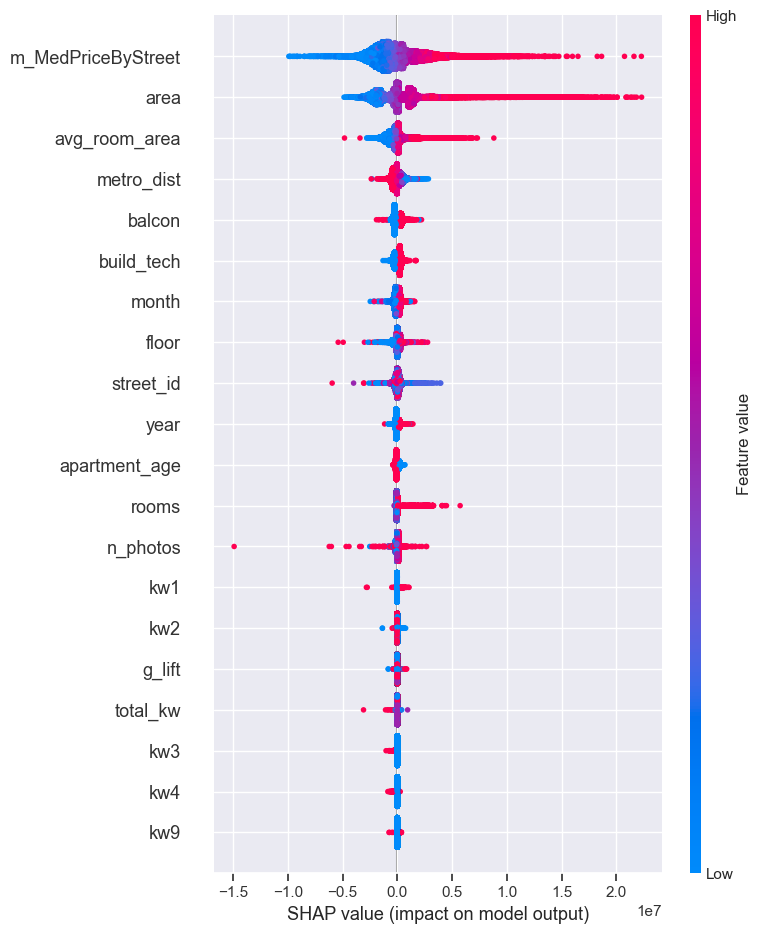

In [187]:
shap.summary_plot(shap_values, X_train_gen)

Посмотрим какие признаки являются самыми важными для модели и как будут меняться предсказания, если выбросить наименее информативные признаки.

In [335]:
train_pool = Pool(X_train_gen, y_train_gen, feature_names=list(X_train_gen.columns))
test_pool = Pool(X_test_gen, y_test_gen, feature_names=list(X_train_gen.columns))

In [339]:
from catboost import EShapCalcType, EFeaturesSelectionAlgorithm

def select_features(algorithm: EFeaturesSelectionAlgorithm, steps: int = 1):
    print('Algorithm:', algorithm)
    model = CatBoostRegressor(iterations=2500, 
                             depth=5, 
                            learning_rate=0.19540795145365197, 
                            l2_leaf_reg=5.035524869752285, 
                            random_seed=42, 
                           loss_function='MAE',
                           verbose=True)
    summary = model.select_features(
        train_pool,
        eval_set=test_pool,
        features_for_select=list(range(train_pool.num_col())),
        num_features_to_select=5,
        steps=steps,
        algorithm=algorithm,
        shap_calc_type=EShapCalcType.Regular,
        train_final_model=True,
        logging_level='Silent',
        plot=True
    )
    print('Selected features:', summary['selected_features_names'])
    return summary

### 3 шага

In [340]:
shap_summary = select_features(algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues, steps=3)

Algorithm: EFeaturesSelectionAlgorithm.RecursiveByShapValues


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Selected features: ['area', 'balcon', 'metro_dist', 'avg_room_area', 'm_MedPriceByStreet']


### 9 шагов

In [341]:
_ = select_features(algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues, steps=9)

Algorithm: EFeaturesSelectionAlgorithm.RecursiveByShapValues


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Selected features: ['area', 'balcon', 'metro_dist', 'avg_room_area', 'm_MedPriceByStreet']


Из графика видно, что минимальный лосс получается, если выкинуть 15 признаков

In [342]:
features_to_drop = ['g_lift', 'total_kw', 'kw13', 'kw10', 'kw11', 'kw2', 'kw12', 
                   'kw6', 'kw8', 'kw5', 'kw7', 'kw9', 'kw4', 'kw3', 'n_photos']

In [343]:
data_drop_features_train = gen_data_train.drop(columns=features_to_drop)
data_drop_features_test = gen_data_test.drop(columns=features_to_drop)

In [344]:
X_drop_features = data_drop_features_train.drop(columns=['price'])
y_drop_features = data_drop_features_train['price']

In [345]:
X_drop_features_train, X_drop_features_test, y_drop_features_train, y_drop_features_test = train_test_split(X_drop_features, 
                                                              y_drop_features, train_size=0.7)

In [346]:
cb_droped = CatBoostRegressor(iterations=2500, 
                             depth=5, 
                            learning_rate=0.19540795145365197, 
                            l2_leaf_reg=5.035524869752285, 
                            random_seed=42, 
                           loss_function='MAE',
                           verbose=True)

In [347]:
cb_droped.fit(X_drop_features_train, y_drop_features_train)

0:	learn: 2280931.6678458	total: 37.3ms	remaining: 1m 33s
1:	learn: 2018631.7345676	total: 56.7ms	remaining: 1m 10s
2:	learn: 1834651.3815393	total: 61.9ms	remaining: 51.5s
3:	learn: 1678189.6715684	total: 65.9ms	remaining: 41.1s
4:	learn: 1541148.7138782	total: 70ms	remaining: 34.9s
5:	learn: 1425416.4111167	total: 74.2ms	remaining: 30.8s
6:	learn: 1350594.2691468	total: 78.4ms	remaining: 27.9s
7:	learn: 1285487.0067165	total: 82.5ms	remaining: 25.7s
8:	learn: 1231456.8953483	total: 86.6ms	remaining: 24s
9:	learn: 1163548.0387173	total: 91ms	remaining: 22.7s
10:	learn: 1111567.3264499	total: 94.8ms	remaining: 21.5s
11:	learn: 1083746.4421662	total: 98.7ms	remaining: 20.5s
12:	learn: 1044725.3079746	total: 103ms	remaining: 19.7s
13:	learn: 1018398.9587371	total: 107ms	remaining: 19s
14:	learn: 1005371.1117971	total: 111ms	remaining: 18.4s
15:	learn: 988669.9996955	total: 115ms	remaining: 17.9s
16:	learn: 968219.0197487	total: 119ms	remaining: 17.4s
17:	learn: 951554.0614797	total: 123m

186:	learn: 698434.7901358	total: 840ms	remaining: 10.4s
187:	learn: 697995.3122768	total: 844ms	remaining: 10.4s
188:	learn: 697824.1372575	total: 849ms	remaining: 10.4s
189:	learn: 697167.7458653	total: 854ms	remaining: 10.4s
190:	learn: 696932.7883257	total: 859ms	remaining: 10.4s
191:	learn: 696498.4853108	total: 863ms	remaining: 10.4s
192:	learn: 696314.6466602	total: 867ms	remaining: 10.4s
193:	learn: 696040.4311814	total: 871ms	remaining: 10.4s
194:	learn: 695867.5447580	total: 876ms	remaining: 10.3s
195:	learn: 695318.4652280	total: 880ms	remaining: 10.3s
196:	learn: 695054.2132908	total: 884ms	remaining: 10.3s
197:	learn: 694707.4690970	total: 888ms	remaining: 10.3s
198:	learn: 694112.8776407	total: 892ms	remaining: 10.3s
199:	learn: 693740.9203577	total: 896ms	remaining: 10.3s
200:	learn: 693332.9980041	total: 900ms	remaining: 10.3s
201:	learn: 693123.5097680	total: 904ms	remaining: 10.3s
202:	learn: 692834.0821468	total: 908ms	remaining: 10.3s
203:	learn: 692539.3269134	tota

370:	learn: 647071.1314546	total: 1.63s	remaining: 9.36s
371:	learn: 646659.0244903	total: 1.64s	remaining: 9.36s
372:	learn: 646585.7759411	total: 1.64s	remaining: 9.35s
373:	learn: 646315.0970115	total: 1.64s	remaining: 9.35s
374:	learn: 646222.0192830	total: 1.65s	remaining: 9.35s
375:	learn: 646111.3428447	total: 1.65s	remaining: 9.34s
376:	learn: 645962.6179653	total: 1.66s	remaining: 9.34s
377:	learn: 645851.6138816	total: 1.66s	remaining: 9.33s
378:	learn: 645725.7169249	total: 1.67s	remaining: 9.32s
379:	learn: 645684.3533537	total: 1.67s	remaining: 9.32s
380:	learn: 645299.0144451	total: 1.67s	remaining: 9.31s
381:	learn: 645115.5520165	total: 1.68s	remaining: 9.31s
382:	learn: 644821.5791713	total: 1.68s	remaining: 9.3s
383:	learn: 644722.2992464	total: 1.69s	remaining: 9.29s
384:	learn: 644589.8109478	total: 1.69s	remaining: 9.29s
385:	learn: 644522.2742979	total: 1.69s	remaining: 9.28s
386:	learn: 644287.8886109	total: 1.7s	remaining: 9.28s
387:	learn: 643929.0055237	total:

553:	learn: 618765.6435645	total: 2.42s	remaining: 8.5s
554:	learn: 618727.5165894	total: 2.42s	remaining: 8.5s
555:	learn: 618564.8475072	total: 2.43s	remaining: 8.5s
556:	learn: 618460.8930151	total: 2.43s	remaining: 8.49s
557:	learn: 618405.1994688	total: 2.44s	remaining: 8.48s
558:	learn: 618338.0849385	total: 2.44s	remaining: 8.48s
559:	learn: 618171.8521087	total: 2.45s	remaining: 8.48s
560:	learn: 618041.6618409	total: 2.45s	remaining: 8.47s
561:	learn: 617940.9903291	total: 2.46s	remaining: 8.47s
562:	learn: 617894.4483405	total: 2.46s	remaining: 8.46s
563:	learn: 617805.9941173	total: 2.46s	remaining: 8.46s
564:	learn: 617462.3681326	total: 2.47s	remaining: 8.45s
565:	learn: 617040.5036636	total: 2.47s	remaining: 8.45s
566:	learn: 616837.0223274	total: 2.48s	remaining: 8.45s
567:	learn: 616821.2437622	total: 2.48s	remaining: 8.44s
568:	learn: 616723.6950845	total: 2.49s	remaining: 8.44s
569:	learn: 616634.3102808	total: 2.49s	remaining: 8.43s
570:	learn: 616580.0647675	total: 

742:	learn: 600189.3170834	total: 3.22s	remaining: 7.62s
743:	learn: 600133.3371762	total: 3.22s	remaining: 7.61s
744:	learn: 599998.2349769	total: 3.23s	remaining: 7.61s
745:	learn: 599955.6342676	total: 3.23s	remaining: 7.6s
746:	learn: 599799.6186893	total: 3.24s	remaining: 7.6s
747:	learn: 599773.2199764	total: 3.24s	remaining: 7.6s
748:	learn: 599661.6926447	total: 3.25s	remaining: 7.59s
749:	learn: 599595.4179802	total: 3.25s	remaining: 7.59s
750:	learn: 599447.2571225	total: 3.26s	remaining: 7.59s
751:	learn: 599425.6204279	total: 3.26s	remaining: 7.58s
752:	learn: 599398.0081849	total: 3.27s	remaining: 7.58s
753:	learn: 599371.3714850	total: 3.27s	remaining: 7.57s
754:	learn: 599318.8321867	total: 3.27s	remaining: 7.57s
755:	learn: 599218.4740603	total: 3.28s	remaining: 7.56s
756:	learn: 599127.7604472	total: 3.28s	remaining: 7.56s
757:	learn: 599084.2110869	total: 3.29s	remaining: 7.56s
758:	learn: 599012.9133210	total: 3.29s	remaining: 7.55s
759:	learn: 598845.9345130	total: 

915:	learn: 587988.9408821	total: 4.02s	remaining: 6.95s
916:	learn: 587921.8205305	total: 4.02s	remaining: 6.95s
917:	learn: 587831.8214956	total: 4.03s	remaining: 6.94s
918:	learn: 587780.7032610	total: 4.03s	remaining: 6.94s
919:	learn: 587753.4300956	total: 4.04s	remaining: 6.93s
920:	learn: 587721.0191366	total: 4.04s	remaining: 6.93s
921:	learn: 587657.3264516	total: 4.05s	remaining: 6.93s
922:	learn: 587513.1804530	total: 4.05s	remaining: 6.92s
923:	learn: 587477.3890391	total: 4.06s	remaining: 6.92s
924:	learn: 587453.8084189	total: 4.06s	remaining: 6.92s
925:	learn: 587384.6369855	total: 4.07s	remaining: 6.91s
926:	learn: 587329.9969466	total: 4.07s	remaining: 6.91s
927:	learn: 587252.8256621	total: 4.08s	remaining: 6.91s
928:	learn: 587189.1760299	total: 4.08s	remaining: 6.9s
929:	learn: 587040.0923763	total: 4.09s	remaining: 6.9s
930:	learn: 586997.0794633	total: 4.09s	remaining: 6.89s
931:	learn: 586975.9337543	total: 4.09s	remaining: 6.89s
932:	learn: 586939.0057608	total:

1103:	learn: 575203.6421448	total: 4.82s	remaining: 6.1s
1104:	learn: 575115.5975525	total: 4.83s	remaining: 6.09s
1105:	learn: 574997.4587037	total: 4.83s	remaining: 6.09s
1106:	learn: 574980.8002425	total: 4.83s	remaining: 6.08s
1107:	learn: 574970.3566438	total: 4.84s	remaining: 6.08s
1108:	learn: 574907.6827425	total: 4.84s	remaining: 6.08s
1109:	learn: 574830.1451598	total: 4.85s	remaining: 6.07s
1110:	learn: 574804.7169398	total: 4.85s	remaining: 6.07s
1111:	learn: 574783.4019221	total: 4.86s	remaining: 6.06s
1112:	learn: 574740.0526671	total: 4.86s	remaining: 6.06s
1113:	learn: 574718.4196562	total: 4.86s	remaining: 6.05s
1114:	learn: 574614.4938197	total: 4.87s	remaining: 6.05s
1115:	learn: 574533.0937896	total: 4.87s	remaining: 6.04s
1116:	learn: 574478.9324285	total: 4.88s	remaining: 6.04s
1117:	learn: 574452.6389232	total: 4.88s	remaining: 6.03s
1118:	learn: 574409.5799147	total: 4.89s	remaining: 6.03s
1119:	learn: 574254.0040853	total: 4.89s	remaining: 6.03s
1120:	learn: 57

1291:	learn: 565119.7444790	total: 5.62s	remaining: 5.25s
1292:	learn: 565072.6554792	total: 5.62s	remaining: 5.25s
1293:	learn: 565025.8162409	total: 5.63s	remaining: 5.24s
1294:	learn: 565004.3120608	total: 5.63s	remaining: 5.24s
1295:	learn: 564978.4324470	total: 5.63s	remaining: 5.23s
1296:	learn: 564875.0902822	total: 5.64s	remaining: 5.23s
1297:	learn: 564870.1746563	total: 5.64s	remaining: 5.23s
1298:	learn: 564851.9911171	total: 5.65s	remaining: 5.22s
1299:	learn: 564826.5618185	total: 5.65s	remaining: 5.22s
1300:	learn: 564810.5146336	total: 5.66s	remaining: 5.21s
1301:	learn: 564752.3209347	total: 5.66s	remaining: 5.21s
1302:	learn: 564708.8494410	total: 5.67s	remaining: 5.2s
1303:	learn: 564684.9493571	total: 5.67s	remaining: 5.2s
1304:	learn: 564669.3973963	total: 5.67s	remaining: 5.19s
1305:	learn: 564630.6230262	total: 5.68s	remaining: 5.19s
1306:	learn: 564592.7400725	total: 5.68s	remaining: 5.19s
1307:	learn: 564548.1402787	total: 5.68s	remaining: 5.18s
1308:	learn: 564

1434:	learn: 560015.9857064	total: 6.21s	remaining: 4.61s
1435:	learn: 560010.9512972	total: 6.22s	remaining: 4.61s
1436:	learn: 559950.7153556	total: 6.22s	remaining: 4.6s
1437:	learn: 559897.7695685	total: 6.23s	remaining: 4.6s
1438:	learn: 559867.2316439	total: 6.23s	remaining: 4.59s
1439:	learn: 559803.9495444	total: 6.24s	remaining: 4.59s
1440:	learn: 559784.9624964	total: 6.24s	remaining: 4.58s
1441:	learn: 559772.6500729	total: 6.24s	remaining: 4.58s
1442:	learn: 559738.1561087	total: 6.25s	remaining: 4.58s
1443:	learn: 559695.0078991	total: 6.25s	remaining: 4.57s
1444:	learn: 559675.7093913	total: 6.26s	remaining: 4.57s
1445:	learn: 559659.8274995	total: 6.26s	remaining: 4.56s
1446:	learn: 559593.9420449	total: 6.26s	remaining: 4.56s
1447:	learn: 559538.0861165	total: 6.27s	remaining: 4.55s
1448:	learn: 559502.7264035	total: 6.27s	remaining: 4.55s
1449:	learn: 559495.6741166	total: 6.28s	remaining: 4.54s
1450:	learn: 559481.2997990	total: 6.28s	remaining: 4.54s
1451:	learn: 559

1608:	learn: 553341.3425683	total: 7.01s	remaining: 3.88s
1609:	learn: 553263.6238610	total: 7.01s	remaining: 3.88s
1610:	learn: 553259.6213945	total: 7.02s	remaining: 3.87s
1611:	learn: 553233.8700368	total: 7.02s	remaining: 3.87s
1612:	learn: 553204.5307488	total: 7.03s	remaining: 3.87s
1613:	learn: 553162.5293421	total: 7.03s	remaining: 3.86s
1614:	learn: 553146.1814526	total: 7.04s	remaining: 3.86s
1615:	learn: 553131.9044357	total: 7.04s	remaining: 3.85s
1616:	learn: 553058.8333730	total: 7.04s	remaining: 3.85s
1617:	learn: 553031.0102699	total: 7.05s	remaining: 3.84s
1618:	learn: 553011.5271580	total: 7.05s	remaining: 3.84s
1619:	learn: 552989.4177324	total: 7.06s	remaining: 3.83s
1620:	learn: 552964.1571773	total: 7.06s	remaining: 3.83s
1621:	learn: 552905.5058674	total: 7.07s	remaining: 3.83s
1622:	learn: 552878.4026162	total: 7.07s	remaining: 3.82s
1623:	learn: 552863.6406247	total: 7.07s	remaining: 3.82s
1624:	learn: 552851.8731545	total: 7.08s	remaining: 3.81s
1625:	learn: 5

1751:	learn: 549263.1454738	total: 7.61s	remaining: 3.25s
1752:	learn: 549205.2145921	total: 7.62s	remaining: 3.25s
1753:	learn: 549188.4040152	total: 7.62s	remaining: 3.24s
1754:	learn: 549186.0848783	total: 7.62s	remaining: 3.24s
1755:	learn: 549142.3741702	total: 7.63s	remaining: 3.23s
1756:	learn: 549128.6261708	total: 7.63s	remaining: 3.23s
1757:	learn: 549116.9924967	total: 7.64s	remaining: 3.22s
1758:	learn: 549094.6060660	total: 7.64s	remaining: 3.22s
1759:	learn: 549048.2716796	total: 7.65s	remaining: 3.21s
1760:	learn: 549017.7904519	total: 7.65s	remaining: 3.21s
1761:	learn: 548963.9285356	total: 7.66s	remaining: 3.21s
1762:	learn: 548947.1252582	total: 7.66s	remaining: 3.2s
1763:	learn: 548933.4000775	total: 7.66s	remaining: 3.2s
1764:	learn: 548863.7110552	total: 7.67s	remaining: 3.19s
1765:	learn: 548832.8996020	total: 7.67s	remaining: 3.19s
1766:	learn: 548788.0955312	total: 7.68s	remaining: 3.18s
1767:	learn: 548757.0281232	total: 7.68s	remaining: 3.18s
1768:	learn: 548

1895:	learn: 545652.4673298	total: 8.21s	remaining: 2.62s
1896:	learn: 545604.8525139	total: 8.22s	remaining: 2.61s
1897:	learn: 545598.0312910	total: 8.22s	remaining: 2.61s
1898:	learn: 545589.7586841	total: 8.23s	remaining: 2.6s
1899:	learn: 545580.8216554	total: 8.23s	remaining: 2.6s
1900:	learn: 545557.2825097	total: 8.23s	remaining: 2.59s
1901:	learn: 545522.1566260	total: 8.24s	remaining: 2.59s
1902:	learn: 545519.4053938	total: 8.24s	remaining: 2.58s
1903:	learn: 545503.6293769	total: 8.25s	remaining: 2.58s
1904:	learn: 545486.7125732	total: 8.25s	remaining: 2.58s
1905:	learn: 545478.1797787	total: 8.26s	remaining: 2.57s
1906:	learn: 545474.6592812	total: 8.26s	remaining: 2.57s
1907:	learn: 545407.3558044	total: 8.26s	remaining: 2.56s
1908:	learn: 545370.6341980	total: 8.27s	remaining: 2.56s
1909:	learn: 545353.1187736	total: 8.27s	remaining: 2.56s
1910:	learn: 545296.1568954	total: 8.28s	remaining: 2.55s
1911:	learn: 545284.9420161	total: 8.28s	remaining: 2.55s
1912:	learn: 545

2082:	learn: 541516.6686342	total: 9s	remaining: 1.8s
2083:	learn: 541501.1656054	total: 9.01s	remaining: 1.8s
2084:	learn: 541495.4783490	total: 9.01s	remaining: 1.79s
2085:	learn: 541464.9389768	total: 9.01s	remaining: 1.79s
2086:	learn: 541437.0399878	total: 9.02s	remaining: 1.78s
2087:	learn: 541389.9155799	total: 9.02s	remaining: 1.78s
2088:	learn: 541356.8900470	total: 9.03s	remaining: 1.77s
2089:	learn: 541330.4117588	total: 9.03s	remaining: 1.77s
2090:	learn: 541307.0699680	total: 9.04s	remaining: 1.77s
2091:	learn: 541302.5956559	total: 9.04s	remaining: 1.76s
2092:	learn: 541291.8106640	total: 9.04s	remaining: 1.76s
2093:	learn: 541266.7804800	total: 9.05s	remaining: 1.75s
2094:	learn: 541259.4477131	total: 9.05s	remaining: 1.75s
2095:	learn: 541246.6700069	total: 9.06s	remaining: 1.75s
2096:	learn: 541231.4924606	total: 9.06s	remaining: 1.74s
2097:	learn: 541210.5618679	total: 9.06s	remaining: 1.74s
2098:	learn: 541159.1865958	total: 9.07s	remaining: 1.73s
2099:	learn: 541145

2224:	learn: 538724.2454051	total: 9.6s	remaining: 1.19s
2225:	learn: 538710.1918418	total: 9.6s	remaining: 1.18s
2226:	learn: 538681.3249092	total: 9.61s	remaining: 1.18s
2227:	learn: 538665.7184445	total: 9.61s	remaining: 1.17s
2228:	learn: 538647.9002063	total: 9.62s	remaining: 1.17s
2229:	learn: 538639.2633237	total: 9.62s	remaining: 1.16s
2230:	learn: 538633.6521377	total: 9.62s	remaining: 1.16s
2231:	learn: 538626.7164621	total: 9.63s	remaining: 1.16s
2232:	learn: 538597.5950891	total: 9.63s	remaining: 1.15s
2233:	learn: 538586.5533780	total: 9.64s	remaining: 1.15s
2234:	learn: 538574.8052268	total: 9.64s	remaining: 1.14s
2235:	learn: 538532.2860206	total: 9.64s	remaining: 1.14s
2236:	learn: 538505.6255168	total: 9.65s	remaining: 1.13s
2237:	learn: 538481.5810903	total: 9.65s	remaining: 1.13s
2238:	learn: 538461.7421890	total: 9.66s	remaining: 1.13s
2239:	learn: 538451.3076363	total: 9.66s	remaining: 1.12s
2240:	learn: 538393.3877696	total: 9.66s	remaining: 1.12s
2241:	learn: 538

2366:	learn: 536115.3060155	total: 10.2s	remaining: 573ms
2367:	learn: 536108.2007213	total: 10.2s	remaining: 569ms
2368:	learn: 536064.6461473	total: 10.2s	remaining: 564ms
2369:	learn: 536045.1897305	total: 10.2s	remaining: 560ms
2370:	learn: 536038.6868806	total: 10.2s	remaining: 556ms
2371:	learn: 536000.4674422	total: 10.2s	remaining: 552ms
2372:	learn: 535995.6575417	total: 10.2s	remaining: 547ms
2373:	learn: 535983.7423970	total: 10.2s	remaining: 543ms
2374:	learn: 535977.8298029	total: 10.2s	remaining: 539ms
2375:	learn: 535967.6855749	total: 10.2s	remaining: 534ms
2376:	learn: 535959.6429379	total: 10.2s	remaining: 530ms
2377:	learn: 535951.5059393	total: 10.2s	remaining: 526ms
2378:	learn: 535895.2248139	total: 10.3s	remaining: 522ms
2379:	learn: 535842.0665353	total: 10.3s	remaining: 517ms
2380:	learn: 535839.7861916	total: 10.3s	remaining: 513ms
2381:	learn: 535811.2415723	total: 10.3s	remaining: 509ms
2382:	learn: 535797.6207023	total: 10.3s	remaining: 504ms
2383:	learn: 5

In [348]:
y_droped_pred = cb_droped.predict(X_drop_features_test)

In [349]:
mean_absolute_error(y_drop_features_test, y_droped_pred)

603724.7422194823

In [350]:
y_droped = cb_droped.predict(data_drop_features_test)

Запишем результат

In [351]:
test_df = pd.DataFrame()

test_df["price"] = y_droped
test_df["id"] = [i for i in range(100000, 200000)]

test_df[["id", "price"]].to_csv("hw_5_submission.csv", index=False)

!cat hw_5_submission.csv | head

id,price
100000,7953218.120598741
100001,4204056.801729841
100002,3972919.976915351
100003,3134981.573747268
100004,6805094.949554047
100005,5106447.371170765
100006,2172268.22072694
100007,1168000.4703605678
100008,3463526.9181782454
cat: stdout: Broken pipe


### Попробуем еще улучшить результат в борьбе за первое место

Во время анализа данных я добавил новый столбец для каждого объекта - цена за квадратный метр. После оценки качества такой модели MAE оказалась равна 16 тысяч, что очень хорошо.
Но так как у нас нет столбца price в тестовом датасете, для него повторить такой столбец не получиться.

Попробуем добавить мета признак. Посчитаем стоимость одного квадратного метра для каждого объекта. Дальше на полученных данных обучим модель, чтобы она предсказывала эту стоимость. И используем эту модель для предсказания стоимости одного квадратного метра в тестовом наборе данных. Добавим полученные предсказания к данным и обучим на полученных данных модель, которая уже будет предсказывать цену.

Так же чтобы попытаться максимизировать результат будем брать предсказания одного и того же CatBoostRegressor с одинаковыми гиперпараметрами, но с разынм `random_seed` и усреднять их.

In [352]:
meta_data = gen_data_train.copy(deep=True)

In [353]:
meta_data['m_price'] = meta_data['price'] / meta_data['area']

In [354]:
meta_data

,street_id,build_tech,floor,area,rooms,balcon,metro_dist,g_lift,n_photos,kw1,...,kw12,kw13,price,year,month,avg_room_area,total_kw,apartment_age,m_MedPriceByStreet,m_price
0,560,1.0,2,59,3,0,30.0,1.0,5,0,...,0,0,4510000,2011,1,19.666667,1,13,86700.000000,76440.677966
1,667,1.0,10,50,2,1,25.0,0.0,1,0,...,0,0,13231000,2011,1,25.000000,1,13,232911.764706,264620.000000
2,90,0.0,1,48,2,0,25.0,0.0,1,0,...,0,0,2008000,2011,1,24.000000,1,13,64299.393939,41833.333333
3,94,1.0,3,62,3,1,30.0,0.0,3,0,...,0,0,12680000,2011,1,20.666667,1,13,282137.216012,204516.129032
4,232,0.0,3,60,3,0,25.0,1.0,3,0,...,0,0,3335000,2011,1,20.000000,1,13,110213.025210,55583.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,401,0.0,5,30,1,0,30.0,1.0,1,0,...,0,0,1697000,2012,3,30.000000,0,12,82255.319149,56566.666667
99996,59,0.0,4,34,1,0,30.0,0.0,1,0,...,0,0,3620000,2012,3,34.000000,1,12,116522.642680,106470.588235
99997,253,1.0,3,52,2,0,5.0,0.0,4,0,...,0,0,6712000,2012,3,26.000000,1,12,69267.350929,129076.923077
99998,305,1.0,3,181,5,1,5.0,0.0,3,0,...,0,0,20835000,2012,3,36.200000,0,12,58175.438596,115110.497238


In [355]:
X_meta = meta_data.drop(columns=['price', 'm_price'])
y_meta = meta_data['m_price']

In [356]:
X_train_meta, X_test_meta, y_train_meta, y_test_meta = train_test_split(X_meta, y_meta, 
                                                            train_size=0.7, random_state=42)

In [359]:
def optimize(params):
    model = CatBoostRegressor(
        iterations=params['iterations'],
        learning_rate=params['learning_rate'],
        depth=int(params['depth']),
        l2_leaf_reg=params['l2_leaf_reg'],
        random_seed=42,
        loss_function='MAE',
        verbose=False
    )

    model.fit(X_train_meta, y_train_meta, eval_set=(X_test_meta, y_test_meta))
 
    y_pred = model.predict(X_test_meta)
    

    mae = mean_absolute_error(y_test_meta, y_pred)
    
    return mae

space = {
    'iterations': hp.quniform('iterations', 500, 3000, 100), 
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'depth': hp.quniform('depth', 3, 10, 1),
    'l2_leaf_reg': hp.uniform('l2_leaf_reg', 1, 10)
}

trials = Trials()

best_params_meta = fmin(fn=optimize, 
                   space=space, 
                   algo=tpe.suggest, 
                   max_evals=50,  
                   trials=trials)

print("Best Hyperparameters:")
print(best_params_meta)

100%|█████████| 50/50 [08:30<00:00, 10.21s/trial, best loss: 10824.324275925712]
Best Hyperparameters:
{'depth': 5.0, 'iterations': 3000.0, 'l2_leaf_reg': 5.8580141374399, 'learning_rate': 0.22709420219339688}


In [360]:
cb_meta = CatBoostRegressor(iterations=3000, 
                                  depth=5, 
                            learning_rate=0.22709420219339688, 
                            l2_leaf_reg=5.8580141374399, 
                            random_seed=42, 
                           loss_function='MAE',
                           verbose=True)

In [361]:
cb_meta.fit(X_train_meta, y_train_meta)

0:	learn: 33359.5573414	total: 7.85ms	remaining: 23.5s
1:	learn: 29221.5301700	total: 13.3ms	remaining: 20s
2:	learn: 26236.0150960	total: 18.3ms	remaining: 18.3s
3:	learn: 24188.8447920	total: 23.1ms	remaining: 17.3s
4:	learn: 22535.5169784	total: 27.8ms	remaining: 16.7s
5:	learn: 21242.8126654	total: 32.6ms	remaining: 16.3s
6:	learn: 19980.1054218	total: 37.3ms	remaining: 16s
7:	learn: 19162.3007868	total: 42ms	remaining: 15.7s
8:	learn: 18366.5085087	total: 46.9ms	remaining: 15.6s
9:	learn: 17698.3295669	total: 51.7ms	remaining: 15.5s
10:	learn: 17187.1225520	total: 56.2ms	remaining: 15.3s
11:	learn: 16775.6499509	total: 60.8ms	remaining: 15.1s
12:	learn: 16517.4476159	total: 65.5ms	remaining: 15.1s
13:	learn: 16246.0552337	total: 70.1ms	remaining: 15s
14:	learn: 16054.8974820	total: 74.8ms	remaining: 14.9s
15:	learn: 15909.5683405	total: 79.7ms	remaining: 14.9s
16:	learn: 15698.2411415	total: 84.3ms	remaining: 14.8s
17:	learn: 15476.1091075	total: 89ms	remaining: 14.7s
18:	learn: 1

174:	learn: 12488.0340493	total: 804ms	remaining: 13s
175:	learn: 12477.6891432	total: 809ms	remaining: 13s
176:	learn: 12471.3736928	total: 813ms	remaining: 13s
177:	learn: 12465.6427729	total: 817ms	remaining: 13s
178:	learn: 12453.6182301	total: 821ms	remaining: 12.9s
179:	learn: 12451.2898909	total: 826ms	remaining: 12.9s
180:	learn: 12439.7603712	total: 831ms	remaining: 12.9s
181:	learn: 12438.0950542	total: 834ms	remaining: 12.9s
182:	learn: 12432.9342511	total: 839ms	remaining: 12.9s
183:	learn: 12426.4953214	total: 843ms	remaining: 12.9s
184:	learn: 12421.9664614	total: 847ms	remaining: 12.9s
185:	learn: 12405.1992121	total: 851ms	remaining: 12.9s
186:	learn: 12400.3410260	total: 856ms	remaining: 12.9s
187:	learn: 12389.7487669	total: 860ms	remaining: 12.9s
188:	learn: 12381.3145526	total: 864ms	remaining: 12.9s
189:	learn: 12375.3998324	total: 868ms	remaining: 12.8s
190:	learn: 12372.8132390	total: 873ms	remaining: 12.8s
191:	learn: 12360.5129177	total: 877ms	remaining: 12.8s


358:	learn: 11513.8280611	total: 1.6s	remaining: 11.8s
359:	learn: 11511.6139442	total: 1.61s	remaining: 11.8s
360:	learn: 11509.5584399	total: 1.61s	remaining: 11.8s
361:	learn: 11507.3391912	total: 1.62s	remaining: 11.8s
362:	learn: 11500.8425548	total: 1.62s	remaining: 11.8s
363:	learn: 11499.4353911	total: 1.63s	remaining: 11.8s
364:	learn: 11497.2215952	total: 1.63s	remaining: 11.8s
365:	learn: 11494.5782862	total: 1.64s	remaining: 11.8s
366:	learn: 11486.6081005	total: 1.64s	remaining: 11.8s
367:	learn: 11484.7580779	total: 1.64s	remaining: 11.8s
368:	learn: 11481.6960184	total: 1.65s	remaining: 11.8s
369:	learn: 11474.1331480	total: 1.65s	remaining: 11.8s
370:	learn: 11471.4557193	total: 1.66s	remaining: 11.7s
371:	learn: 11466.7815766	total: 1.66s	remaining: 11.7s
372:	learn: 11463.3535505	total: 1.67s	remaining: 11.7s
373:	learn: 11461.2932632	total: 1.67s	remaining: 11.7s
374:	learn: 11458.0903094	total: 1.68s	remaining: 11.7s
375:	learn: 11456.6955903	total: 1.68s	remaining:

541:	learn: 10997.3012264	total: 2.41s	remaining: 10.9s
542:	learn: 10989.2137994	total: 2.41s	remaining: 10.9s
543:	learn: 10982.7121521	total: 2.42s	remaining: 10.9s
544:	learn: 10981.7590334	total: 2.42s	remaining: 10.9s
545:	learn: 10981.0661807	total: 2.43s	remaining: 10.9s
546:	learn: 10979.9522197	total: 2.43s	remaining: 10.9s
547:	learn: 10977.8126057	total: 2.44s	remaining: 10.9s
548:	learn: 10975.9274323	total: 2.44s	remaining: 10.9s
549:	learn: 10974.5091182	total: 2.45s	remaining: 10.9s
550:	learn: 10973.1125537	total: 2.45s	remaining: 10.9s
551:	learn: 10971.0017797	total: 2.46s	remaining: 10.9s
552:	learn: 10969.4161708	total: 2.46s	remaining: 10.9s
553:	learn: 10967.9451697	total: 2.46s	remaining: 10.9s
554:	learn: 10966.6314338	total: 2.47s	remaining: 10.9s
555:	learn: 10963.4022866	total: 2.47s	remaining: 10.9s
556:	learn: 10962.8716198	total: 2.48s	remaining: 10.9s
557:	learn: 10957.0033499	total: 2.48s	remaining: 10.9s
558:	learn: 10950.5374943	total: 2.48s	remaining

721:	learn: 10623.6701785	total: 3.21s	remaining: 10.1s
722:	learn: 10621.3053548	total: 3.21s	remaining: 10.1s
723:	learn: 10619.0289081	total: 3.25s	remaining: 10.2s
724:	learn: 10616.4520171	total: 3.3s	remaining: 10.4s
725:	learn: 10615.7296604	total: 3.31s	remaining: 10.4s
726:	learn: 10614.9003151	total: 3.33s	remaining: 10.4s
727:	learn: 10613.1980513	total: 3.33s	remaining: 10.4s
728:	learn: 10611.7459879	total: 3.34s	remaining: 10.4s
729:	learn: 10610.9064789	total: 3.34s	remaining: 10.4s
730:	learn: 10609.4329219	total: 3.34s	remaining: 10.4s
731:	learn: 10608.7249051	total: 3.35s	remaining: 10.4s
732:	learn: 10607.6297971	total: 3.35s	remaining: 10.4s
733:	learn: 10606.5612885	total: 3.36s	remaining: 10.4s
734:	learn: 10605.7684863	total: 3.36s	remaining: 10.4s
735:	learn: 10603.4907683	total: 3.37s	remaining: 10.4s
736:	learn: 10601.7282213	total: 3.37s	remaining: 10.4s
737:	learn: 10600.8667771	total: 3.38s	remaining: 10.3s
738:	learn: 10600.4056076	total: 3.38s	remaining:

877:	learn: 10405.3361936	total: 4.01s	remaining: 9.69s
878:	learn: 10404.8239620	total: 4.01s	remaining: 9.68s
879:	learn: 10404.0400155	total: 4.01s	remaining: 9.67s
880:	learn: 10403.8358086	total: 4.02s	remaining: 9.67s
881:	learn: 10402.2019906	total: 4.02s	remaining: 9.66s
882:	learn: 10401.8829845	total: 4.03s	remaining: 9.66s
883:	learn: 10400.2547633	total: 4.03s	remaining: 9.65s
884:	learn: 10399.8607069	total: 4.04s	remaining: 9.65s
885:	learn: 10399.0903307	total: 4.04s	remaining: 9.64s
886:	learn: 10398.7694582	total: 4.04s	remaining: 9.64s
887:	learn: 10397.7551166	total: 4.05s	remaining: 9.63s
888:	learn: 10397.4182169	total: 4.05s	remaining: 9.63s
889:	learn: 10396.4375563	total: 4.06s	remaining: 9.62s
890:	learn: 10395.0333394	total: 4.06s	remaining: 9.62s
891:	learn: 10394.6766169	total: 4.07s	remaining: 9.61s
892:	learn: 10393.0075946	total: 4.07s	remaining: 9.61s
893:	learn: 10392.0129346	total: 4.08s	remaining: 9.6s
894:	learn: 10391.4917897	total: 4.08s	remaining:

1063:	learn: 10210.8012094	total: 4.8s	remaining: 8.74s
1064:	learn: 10210.2139071	total: 4.81s	remaining: 8.74s
1065:	learn: 10209.3494588	total: 4.81s	remaining: 8.73s
1066:	learn: 10208.7177905	total: 4.82s	remaining: 8.73s
1067:	learn: 10207.6503995	total: 4.82s	remaining: 8.72s
1068:	learn: 10206.7741488	total: 4.83s	remaining: 8.72s
1069:	learn: 10206.4916197	total: 4.83s	remaining: 8.71s
1070:	learn: 10205.5908623	total: 4.83s	remaining: 8.71s
1071:	learn: 10205.1533005	total: 4.84s	remaining: 8.7s
1072:	learn: 10203.5783757	total: 4.84s	remaining: 8.7s
1073:	learn: 10202.6388086	total: 4.85s	remaining: 8.7s
1074:	learn: 10201.9436575	total: 4.85s	remaining: 8.69s
1075:	learn: 10200.6082914	total: 4.86s	remaining: 8.69s
1076:	learn: 10200.1651018	total: 4.86s	remaining: 8.68s
1077:	learn: 10200.0283697	total: 4.87s	remaining: 8.68s
1078:	learn: 10199.5243100	total: 4.87s	remaining: 8.67s
1079:	learn: 10198.8719654	total: 4.87s	remaining: 8.66s
1080:	learn: 10198.3092062	total: 4

1251:	learn: 10088.4322217	total: 5.61s	remaining: 7.83s
1252:	learn: 10088.2149401	total: 5.61s	remaining: 7.82s
1253:	learn: 10087.7475022	total: 5.61s	remaining: 7.82s
1254:	learn: 10087.2958599	total: 5.62s	remaining: 7.81s
1255:	learn: 10086.8818066	total: 5.62s	remaining: 7.81s
1256:	learn: 10086.0746555	total: 5.63s	remaining: 7.8s
1257:	learn: 10085.3811074	total: 5.63s	remaining: 7.8s
1258:	learn: 10083.7484959	total: 5.64s	remaining: 7.79s
1259:	learn: 10082.4478601	total: 5.64s	remaining: 7.79s
1260:	learn: 10080.5933519	total: 5.64s	remaining: 7.79s
1261:	learn: 10080.2764970	total: 5.65s	remaining: 7.78s
1262:	learn: 10079.9364719	total: 5.65s	remaining: 7.78s
1263:	learn: 10079.2391503	total: 5.66s	remaining: 7.77s
1264:	learn: 10078.9714408	total: 5.66s	remaining: 7.77s
1265:	learn: 10078.2873939	total: 5.67s	remaining: 7.76s
1266:	learn: 10077.4618304	total: 5.67s	remaining: 7.76s
1267:	learn: 10076.5799434	total: 5.67s	remaining: 7.75s
1268:	learn: 10075.9901742	total:

1439:	learn: 9966.9866547	total: 6.41s	remaining: 6.94s
1440:	learn: 9966.3326367	total: 6.41s	remaining: 6.93s
1441:	learn: 9966.0646380	total: 6.41s	remaining: 6.93s
1442:	learn: 9965.5076782	total: 6.42s	remaining: 6.92s
1443:	learn: 9965.3695541	total: 6.42s	remaining: 6.92s
1444:	learn: 9964.9777925	total: 6.43s	remaining: 6.92s
1445:	learn: 9964.6753646	total: 6.43s	remaining: 6.91s
1446:	learn: 9964.4496660	total: 6.43s	remaining: 6.91s
1447:	learn: 9964.2128818	total: 6.44s	remaining: 6.9s
1448:	learn: 9964.0014609	total: 6.44s	remaining: 6.9s
1449:	learn: 9963.7587881	total: 6.45s	remaining: 6.89s
1450:	learn: 9963.6288337	total: 6.45s	remaining: 6.89s
1451:	learn: 9962.2518248	total: 6.46s	remaining: 6.88s
1452:	learn: 9962.0480263	total: 6.46s	remaining: 6.88s
1453:	learn: 9959.7454758	total: 6.46s	remaining: 6.87s
1454:	learn: 9959.3808561	total: 6.47s	remaining: 6.87s
1455:	learn: 9958.4448058	total: 6.47s	remaining: 6.86s
1456:	learn: 9957.9829535	total: 6.48s	remaining: 

1627:	learn: 9869.3195428	total: 7.2s	remaining: 6.07s
1628:	learn: 9869.0936051	total: 7.21s	remaining: 6.06s
1629:	learn: 9868.1821357	total: 7.21s	remaining: 6.06s
1630:	learn: 9867.1516857	total: 7.21s	remaining: 6.05s
1631:	learn: 9865.5935467	total: 7.22s	remaining: 6.05s
1632:	learn: 9864.9262215	total: 7.22s	remaining: 6.05s
1633:	learn: 9864.4756449	total: 7.23s	remaining: 6.04s
1634:	learn: 9864.2428657	total: 7.23s	remaining: 6.04s
1635:	learn: 9864.1497203	total: 7.24s	remaining: 6.03s
1636:	learn: 9863.9251416	total: 7.24s	remaining: 6.03s
1637:	learn: 9862.3227055	total: 7.24s	remaining: 6.02s
1638:	learn: 9861.9083539	total: 7.25s	remaining: 6.02s
1639:	learn: 9861.4171511	total: 7.25s	remaining: 6.01s
1640:	learn: 9859.8741541	total: 7.26s	remaining: 6.01s
1641:	learn: 9859.7179206	total: 7.26s	remaining: 6s
1642:	learn: 9859.2367182	total: 7.26s	remaining: 6s
1643:	learn: 9858.3823077	total: 7.27s	remaining: 6s
1644:	learn: 9857.5694259	total: 7.27s	remaining: 5.99s
16

1818:	learn: 9786.6691986	total: 8.01s	remaining: 5.2s
1819:	learn: 9786.6526342	total: 8.01s	remaining: 5.19s
1820:	learn: 9786.5428304	total: 8.02s	remaining: 5.19s
1821:	learn: 9786.3031347	total: 8.02s	remaining: 5.18s
1822:	learn: 9785.9897244	total: 8.02s	remaining: 5.18s
1823:	learn: 9785.0840994	total: 8.03s	remaining: 5.17s
1824:	learn: 9784.9116209	total: 8.03s	remaining: 5.17s
1825:	learn: 9784.4619072	total: 8.04s	remaining: 5.17s
1826:	learn: 9783.9992555	total: 8.04s	remaining: 5.16s
1827:	learn: 9783.8580835	total: 8.04s	remaining: 5.16s
1828:	learn: 9783.5345098	total: 8.05s	remaining: 5.15s
1829:	learn: 9783.4005683	total: 8.05s	remaining: 5.15s
1830:	learn: 9783.2221216	total: 8.06s	remaining: 5.14s
1831:	learn: 9782.9303105	total: 8.06s	remaining: 5.14s
1832:	learn: 9782.6884738	total: 8.07s	remaining: 5.13s
1833:	learn: 9782.5123733	total: 8.07s	remaining: 5.13s
1834:	learn: 9782.1470413	total: 8.07s	remaining: 5.13s
1835:	learn: 9782.0892484	total: 8.08s	remaining:

2006:	learn: 9719.1395901	total: 8.8s	remaining: 4.36s
2007:	learn: 9719.0598347	total: 8.81s	remaining: 4.35s
2008:	learn: 9719.0042000	total: 8.81s	remaining: 4.35s
2009:	learn: 9718.0394191	total: 8.82s	remaining: 4.34s
2010:	learn: 9717.8130566	total: 8.82s	remaining: 4.34s
2011:	learn: 9717.6454381	total: 8.83s	remaining: 4.33s
2012:	learn: 9717.1781642	total: 8.83s	remaining: 4.33s
2013:	learn: 9717.0987913	total: 8.84s	remaining: 4.33s
2014:	learn: 9716.7348544	total: 8.84s	remaining: 4.32s
2015:	learn: 9716.6296605	total: 8.85s	remaining: 4.32s
2016:	learn: 9716.0814773	total: 8.85s	remaining: 4.31s
2017:	learn: 9715.9280873	total: 8.85s	remaining: 4.31s
2018:	learn: 9715.6690596	total: 8.86s	remaining: 4.3s
2019:	learn: 9715.1045177	total: 8.86s	remaining: 4.3s
2020:	learn: 9714.4566928	total: 8.87s	remaining: 4.29s
2021:	learn: 9713.9106740	total: 8.87s	remaining: 4.29s
2022:	learn: 9713.7646067	total: 8.87s	remaining: 4.29s
2023:	learn: 9713.7265358	total: 8.88s	remaining: 4

2196:	learn: 9659.6600064	total: 9.61s	remaining: 3.51s
2197:	learn: 9659.6252411	total: 9.61s	remaining: 3.51s
2198:	learn: 9659.2669407	total: 9.62s	remaining: 3.5s
2199:	learn: 9659.2178695	total: 9.62s	remaining: 3.5s
2200:	learn: 9659.1079291	total: 9.63s	remaining: 3.49s
2201:	learn: 9658.8638874	total: 9.63s	remaining: 3.49s
2202:	learn: 9658.3003326	total: 9.63s	remaining: 3.48s
2203:	learn: 9658.0135489	total: 9.64s	remaining: 3.48s
2204:	learn: 9657.8094308	total: 9.64s	remaining: 3.48s
2205:	learn: 9657.5839612	total: 9.65s	remaining: 3.47s
2206:	learn: 9657.1315137	total: 9.65s	remaining: 3.47s
2207:	learn: 9656.9670233	total: 9.65s	remaining: 3.46s
2208:	learn: 9656.6389963	total: 9.66s	remaining: 3.46s
2209:	learn: 9656.4068138	total: 9.66s	remaining: 3.45s
2210:	learn: 9656.3063310	total: 9.67s	remaining: 3.45s
2211:	learn: 9655.7997946	total: 9.67s	remaining: 3.44s
2212:	learn: 9654.6391333	total: 9.68s	remaining: 3.44s
2213:	learn: 9654.5655022	total: 9.68s	remaining: 

2370:	learn: 9608.8964350	total: 10.4s	remaining: 2.76s
2371:	learn: 9608.7418046	total: 10.4s	remaining: 2.76s
2372:	learn: 9608.3626167	total: 10.4s	remaining: 2.75s
2373:	learn: 9607.9528759	total: 10.4s	remaining: 2.75s
2374:	learn: 9607.8128939	total: 10.4s	remaining: 2.74s
2375:	learn: 9607.7606546	total: 10.4s	remaining: 2.74s
2376:	learn: 9607.5023707	total: 10.4s	remaining: 2.73s
2377:	learn: 9607.3023300	total: 10.4s	remaining: 2.73s
2378:	learn: 9607.0411723	total: 10.4s	remaining: 2.73s
2379:	learn: 9606.9873564	total: 10.4s	remaining: 2.72s
2380:	learn: 9606.7318128	total: 10.4s	remaining: 2.72s
2381:	learn: 9606.4218271	total: 10.5s	remaining: 2.71s
2382:	learn: 9605.9080781	total: 10.5s	remaining: 2.71s
2383:	learn: 9605.7975249	total: 10.5s	remaining: 2.7s
2384:	learn: 9605.7633359	total: 10.5s	remaining: 2.7s
2385:	learn: 9605.5915273	total: 10.5s	remaining: 2.69s
2386:	learn: 9605.4110237	total: 10.5s	remaining: 2.69s
2387:	learn: 9605.3891078	total: 10.5s	remaining: 

2560:	learn: 9559.1515325	total: 11.2s	remaining: 1.92s
2561:	learn: 9558.9814369	total: 11.2s	remaining: 1.92s
2562:	learn: 9558.7769775	total: 11.2s	remaining: 1.91s
2563:	learn: 9558.3986391	total: 11.2s	remaining: 1.91s
2564:	learn: 9558.2278640	total: 11.2s	remaining: 1.9s
2565:	learn: 9557.9595592	total: 11.2s	remaining: 1.9s
2566:	learn: 9557.7741877	total: 11.2s	remaining: 1.9s
2567:	learn: 9557.4348345	total: 11.2s	remaining: 1.89s
2568:	learn: 9557.0582717	total: 11.2s	remaining: 1.89s
2569:	learn: 9556.8918082	total: 11.2s	remaining: 1.88s
2570:	learn: 9556.8579374	total: 11.3s	remaining: 1.88s
2571:	learn: 9556.7037528	total: 11.3s	remaining: 1.87s
2572:	learn: 9556.6002506	total: 11.3s	remaining: 1.87s
2573:	learn: 9556.5185211	total: 11.3s	remaining: 1.86s
2574:	learn: 9556.2820362	total: 11.3s	remaining: 1.86s
2575:	learn: 9555.6744664	total: 11.3s	remaining: 1.85s
2576:	learn: 9555.5585411	total: 11.3s	remaining: 1.85s
2577:	learn: 9555.2485260	total: 11.3s	remaining: 1

2751:	learn: 9513.6744425	total: 12s	remaining: 1.08s
2752:	learn: 9513.6425729	total: 12s	remaining: 1.08s
2753:	learn: 9513.5295507	total: 12s	remaining: 1.07s
2754:	learn: 9513.4310573	total: 12s	remaining: 1.07s
2755:	learn: 9512.6432908	total: 12s	remaining: 1.06s
2756:	learn: 9512.5234763	total: 12s	remaining: 1.06s
2757:	learn: 9512.3131567	total: 12s	remaining: 1.06s
2758:	learn: 9512.2661825	total: 12s	remaining: 1.05s
2759:	learn: 9511.3562866	total: 12s	remaining: 1.05s
2760:	learn: 9511.2908591	total: 12.1s	remaining: 1.04s
2761:	learn: 9510.9521408	total: 12.1s	remaining: 1.04s
2762:	learn: 9510.2170659	total: 12.1s	remaining: 1.03s
2763:	learn: 9509.9757640	total: 12.1s	remaining: 1.03s
2764:	learn: 9509.7899716	total: 12.1s	remaining: 1.02s
2765:	learn: 9509.5204069	total: 12.1s	remaining: 1.02s
2766:	learn: 9509.4714143	total: 12.1s	remaining: 1.02s
2767:	learn: 9509.3861611	total: 12.1s	remaining: 1.01s
2768:	learn: 9509.3350681	total: 12.1s	remaining: 1.01s
2769:	lear

2940:	learn: 9475.0076417	total: 12.8s	remaining: 257ms
2941:	learn: 9474.8175564	total: 12.8s	remaining: 253ms
2942:	learn: 9474.6787374	total: 12.8s	remaining: 248ms
2943:	learn: 9474.3646356	total: 12.8s	remaining: 244ms
2944:	learn: 9474.2298921	total: 12.8s	remaining: 240ms
2945:	learn: 9474.1516740	total: 12.8s	remaining: 235ms
2946:	learn: 9473.7306668	total: 12.8s	remaining: 231ms
2947:	learn: 9473.6832827	total: 12.8s	remaining: 227ms
2948:	learn: 9473.5690819	total: 12.8s	remaining: 222ms
2949:	learn: 9473.4591128	total: 12.9s	remaining: 218ms
2950:	learn: 9473.2033648	total: 12.9s	remaining: 213ms
2951:	learn: 9472.9012400	total: 12.9s	remaining: 209ms
2952:	learn: 9472.3644234	total: 12.9s	remaining: 205ms
2953:	learn: 9471.9862862	total: 12.9s	remaining: 200ms
2954:	learn: 9471.0061549	total: 12.9s	remaining: 196ms
2955:	learn: 9470.9578442	total: 12.9s	remaining: 192ms
2956:	learn: 9470.8756240	total: 12.9s	remaining: 187ms
2957:	learn: 9470.6454263	total: 12.9s	remaining

In [362]:
m_price_pred = cb_meta.predict(X_meta)

In [363]:
meta_data.drop(columns=['m_price'], inplace=True)

In [364]:
meta_data['m_price'] = m_price_pred

In [375]:
pred_sum = 0
counter = 0
for i in range(10):
    cb_last = CatBoostRegressor(iterations=3000, 
                                  depth=5, 
                            learning_rate=0.22709420219339688, 
                            l2_leaf_reg=5.8580141374399, 
                            random_seed=np.random.randint(1, 1000), 
                           loss_function='MAE',
                           verbose=False)
    cb_last.fit(X_meta, y_meta)
    y_pred_beg = cb_last.predict(gen_data_test)
    pred_sum += y_pred_beg
    counter += 1
    print(f"Моделей обучено:{i + 1}")

Моделей обучено:1
Моделей обучено:2
Моделей обучено:3
Моделей обучено:4
Моделей обучено:5
Моделей обучено:6
Моделей обучено:7
Моделей обучено:8
Моделей обучено:9
Моделей обучено:10


In [376]:
test_meta_price = pred_sum / counter

In [377]:
gen_data_test['m_price'] = test_meta

In [378]:
gen_data_test

,street_id,build_tech,floor,area,rooms,balcon,metro_dist,g_lift,n_photos,kw1,...,kw11,kw12,kw13,year,month,avg_room_area,total_kw,apartment_age,m_MedPriceByStreet,m_price
0,459,1.0,1,60,3,1,30.0,0.0,4,0,...,0,0,0,2012,3,20.000000,0,12,123667.410714,137410.278813
1,344,1.0,10,52,2,1,30.0,0.0,4,0,...,0,0,0,2012,3,26.000000,0,12,67014.860140,81892.941029
2,585,0.0,4,54,3,0,30.0,0.0,0,0,...,0,0,0,2012,3,18.000000,0,12,107870.212766,74253.470005
3,494,1.0,2,52,2,1,25.0,1.0,3,0,...,0,0,0,2012,3,26.000000,1,12,50349.206349,59880.452413
4,622,1.0,9,60,3,1,15.0,0.5,1,1,...,0,0,0,2012,3,20.000000,2,12,73385.416667,112780.412022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,613,1.0,2,34,1,1,25.0,0.0,2,0,...,0,0,0,2013,9,34.000000,1,11,49161.290323,60934.684315
99996,167,1.0,10,61,3,1,30.0,0.0,4,0,...,0,0,0,2013,9,20.333333,1,11,81235.294118,97461.223855
99997,391,1.0,9,34,1,1,30.0,0.5,3,0,...,0,0,0,2013,9,34.000000,1,11,133657.203390,137448.773049
99998,21,0.0,7,58,3,0,30.0,0.0,3,0,...,0,0,0,2013,9,19.333333,0,11,81417.322835,67686.799598


In [379]:
X_meta_price = meta_data.drop(columns=['price'])
y_meta_price = meta_data['price']

In [380]:
pred_sum = 0
counter = 0
for i in range(10):
    cb_last = CatBoostRegressor(iterations=2500, 
                depth=5, 
                learning_rate=0.19540795145365197, 
                l2_leaf_reg=5.035524869752285, 
               random_seed=np.random.randint(1, 1000), 
              loss_function='MAE',
                 verbose=False)
    cb_last.fit(X_meta_price, y_meta_price)
    y_pred_beg = cb_last.predict(gen_data_test)
    pred_sum += y_pred_beg
    counter += 1
    print(f"Моделей обучено:{i + 1}")

Моделей обучено:1
Моделей обучено:2
Моделей обучено:3
Моделей обучено:4
Моделей обучено:5
Моделей обучено:6
Моделей обучено:7
Моделей обучено:8
Моделей обучено:9
Моделей обучено:10


In [381]:
test_meta_price = pred_sum / counter

In [382]:
test_df = pd.DataFrame()

test_df["price"] = test_meta_price
test_df["id"] = [i for i in range(100000, 200000)]

test_df[["id", "price"]].to_csv("hw_5_submission_4.csv", index=False)

!cat hw_5_submission_4.csv | head

id,price
100000,8582449.299922762
100001,4283206.57613975
100002,3993860.374568117
100003,3122625.03624743
100004,7158378.439050393
100005,5193550.545011848
100006,2136587.974026493
100007,1180848.0334492982
100008,3305780.891763678
cat: stdout: Broken pipe


Ура! 3 место